# Libraries and Model

In this tutorial, we will take a closer look at a recent new trend: Transformers for Computer Vision. Since [Alexey Dosovitskiy et al.](https://openreview.net/pdf?id=YicbFdNTTy) successfully applied a Transformer on a variety of image recognition benchmarks, there have been an incredible amount of follow-up works showing that CNNs might not be optimal architecture for Computer Vision anymore. But how do Vision Transformers work exactly, and what benefits and drawbacks do they offer in contrast to CNNs? We will answer these questions by implementing a Vision Transformer ourselves and train it on the popular, small dataset CIFAR10. We will compare these results to the convolutional architectures of [Tutorial 5](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.html).

If you are not familiar with Transformers yet, take a look at [Tutorial 6](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html) where we discuss the fundamentals of Multi-Head Attention and Transformers. As in many previous tutorials, we will use [PyTorch Lightning](https://www.pytorchlightning.ai/) again (introduced in [Tutorial 5](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.html)). Let's start with importing our standard set of libraries.

## Libraries

In [ ]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial
from PIL import Image

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize, BoundaryNorm
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import DataLoader

## Torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial15"


# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

from google.colab import drive
drive.mount('/content/gdrive')
data_PATH = "gdrive/MyDrive/Transformer_to_Potts/"

<ipython-input-1-d546a4a43586>:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Device: cuda:0
Mounted at /content/gdrive


<Figure size 640x480 with 0 Axes>

## Architecture

### Blocks

In [ ]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

# Helper function to support different mask shapes.
# Output shape supports (batch_size, number of heads, seq length, seq length)
# If 2D: broadcasted over batch size and number of heads
# If 3D: broadcasted over number of heads
# If 4D: leave as is
def expand_mask(mask):
    assert mask.ndim > 2, "Mask must be at least 2-dimensional with seq_length x seq_length"
    if mask.ndim == 3:
        mask = mask.unsqueeze(1)
    while mask.ndim < 4:
        mask = mask.unsqueeze(0)
    return mask

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        self.pe = self.pe[:, :x.size(1)]
        return self.pe.expand(x.size(0),-1,-1)   #expand the zero dim along the batch dimension

In [ ]:
class Multihead_Attention(nn.Module):

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(embed_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

In [ ]:
class AttentionBlock(nn.Module):

    def __init__(self, embed_dim, MLP_hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = Multihead_Attention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, MLP_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(MLP_hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, mask=None):
        inp_x = self.layer_norm_1(x)
        #x = x + self.attn(inp_x, inp_x, inp_x)[0]  COME ERA FATTO CON NATIVO PYTORCH
        x = x + self.attn(inp_x, mask=mask)
        x = self.layer_norm_2(x)
        x = x + self.linear(x)
        return x

In [ ]:
class TransformerEncoder_k_layers(nn.Module):

    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([AttentionBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for l in self.layers:
            x = l(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x)
        return attention_maps

### Transformers

In [ ]:
class VIT_k_layers(nn.Module):

    def __init__(self, embed_dim, MLP_hidden_dim, num_channels, num_heads, num_layers, patch_size, num_patches, dropout=0.0, add_positional_encoding=True):
        """
        Inputs:
            embed_dim - Dimensionhe input (3 for RGB)
            num_heads - Number of heads to use in ality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of tthe Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super(VIT_k_layers, self).__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels*(patch_size**2), embed_dim)
        #self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, MLP_hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])
        self.transformer = TransformerEncoder_k_layers(num_layers=num_layers,
                                                       embed_dim=embed_dim,
                                                       MLP_hidden_dim=MLP_hidden_dim,
                                                       num_heads=num_heads,
                                                       dropout=dropout)

        self.output_layer = nn.Linear(embed_dim, num_channels*(patch_size**2))

        self.positional_encoding = PositionalEncoding(d_model=embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.add_positional_encoding = add_positional_encoding

        # Parameters/Embeddings
        #self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        #self.pos_embedding = nn.Parameter(torch.randn(1,1+num_patches,embed_dim))

    def get_attention_maps(self, x):
        x = self.input_layer(x)
        if self.add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=None)
        return attention_maps

    def parallel_step(self, x, mask=None):
        x = self.transformer(x, mask=mask)
        return x

    def embed(self, x):
        x = self.input_layer(x)
        # Add positional encoding
        #x = x + self.pos_embedding[:,:T+1]
        #x = x + self.pos_embedding[:,:T]
        if self.add_positional_encoding:
            x = x + self.positional_encoding(x)
        return x

    def de_embed(self, x):
        if self.add_positional_encoding:
            x = x - self.positional_encoding(x)
        x = self.output_layer(x)
        return x

    def forward(self, x, mask=None):
        # Embed the input
        x = self.input_layer(x)

        # Add positional encoding
        #x = x + self.pos_embedding[:,:T+1]
        #x = x + self.pos_embedding[:,:T]
        if self.add_positional_encoding:
            x = x + self.positional_encoding(x)

        #x = x.transpose(0, 1)
        x = self.transformer(x, mask=mask)
        if self.add_positional_encoding:
            x = x - self.positional_encoding(x)
        x = self.output_layer(x)

        return x

In [ ]:
class VIT_k_rep(nn.Module):

    def __init__(self, embed_dim, MLP_hidden_dim, num_channels, num_heads, num_layers, patch_size, num_patches, dropout=0.0, add_positional_encoding=True):
        """
        Inputs:
            embed_dim - Dimensionhe input (3 for RGB)
            num_heads - Number of heads to use in ality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of tthe Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super(VIT_k_rep, self).__init__()

        self.patch_size = patch_size

        # Layers/Networks
        #self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, MLP_hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])
        self.encoder_repeated = TransformerEncoder_k_layers(num_layers=num_layers,
                                                            embed_dim=embed_dim,
                                                            MLP_hidden_dim=MLP_hidden_dim,
                                                            num_heads=num_heads,
                                                            dropout=dropout)

        self.layers = nn.ModuleList([self.encoder_repeated for _ in range(num_layers)])
        self.input_layer = nn.Linear(num_channels*(patch_size**2), embed_dim)
        self.output_layer = nn.Linear(embed_dim, num_channels*(patch_size**2))

        self.positional_encoding = PositionalEncoding(d_model=embed_dim)
        #self.pos_encoding = nn.Parameter(torch.randn(1,num_patches,embed_dim))
        self.dropout = nn.Dropout(dropout)
        self.add_positional_encoding = add_positional_encoding

        # Parameters/Embeddings
        #self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        #self.pos_embedding = nn.Parameter(torch.randn(1,1+num_patches,embed_dim))

    def get_attention_maps(self, x):
        x = self.input_layer(x)
        if self.add_positional_encoding:
            x = x + self.positional_encoding(x)
        attention_maps = []
        for l in layers:
            _, attn_map = l.self_attn(x,  return_attention=True)
            attention_maps.append(attn_map)
            x = l(x)
        return attention_maps

    def repeat(self, x, repetitions):
        x = self.input_layer(x)
        if self.add_positional_encoding:
            x = x + self.positional_encoding(x)
        for i in range(repetitions):
            x = self.encoder_repeated(x)
        x = self.output_layer(x)
        return x

    def embed(self, x):
        x = self.input_layer(x)
        # Add positional encoding
        #x = x + self.pos_embedding[:,:T+1]
        #x = x + self.pos_embedding[:,:T]
        if self.add_positional_encoding:
            x = x + self.positional_encoding(x)
        return x

    def de_embed(self, x):
        if self.add_positional_encoding:
            x = x #- self.positional_encoding(x)
        x = self.output_layer(x)
        return x

    def parallel_step(self, x, mask=None):
        x = self.encoder_repeated(x, mask=mask)
        return x

    def repeat_embed(self,x,repetitions):
        if self.add_positional_encoding:
            x = x + self.positional_encoding(x)
        for i in range(repetitions):
            x = self.encoder_repeated(x)
        return x

    def forward(self, x, repetitions=1, mask=None):
        # Embed the input
        x = self.input_layer(x)

        # Add positional encoding
        #x = x + self.pos_embedding[:,:T+1]
        #x = x + self.pos_embedding[:,:T]
        if self.add_positional_encoding:
            x = x + self.positional_encoding(x)

        # Apply Transforrmer
        x = self.dropout(x)
        #x = x.transpose(0, 1)
        for i in range(repetitions):
            if i==0:
                x = self.encoder_repeated(x, mask=mask)
            else:
                x = self.encoder_repeated(x)
        x = self.output_layer(x)

        return x

## Metrics, loss, scheduler

In [ ]:
# Perform prediction and calculate loss         pred.size =  torch.Size([64, 64, 48]);
def loss_func(pred, labels, inp_data, rand_index, alpha=1):                             #labels.size = torch.Size([64, 1, 48])
                                                                       #rand_indeces.size = torch.Size([64, 1])
    batch_size = pred.size(0)                                              #positions of elements
    labels_pred = torch.gather(pred, 1, rand_index).squeeze()

    loss = F.mse_loss(labels_pred, labels)+alpha*F.mse_loss(pred,inp_data)
    return loss

#metric accuracy
def accuracy(pred, labels, rand_index):
    batch_size = pred.size(0)

    labels_pred = torch.gather(pred, 1, rand_index).squeeze()

    #compute loss
    acc = F.l1_loss(labels_pred, labels)
    return acc


In [ ]:
#Checkpoints (to save model parameters during training)
class SaveBestModel:
    def __init__(self, name, best_valid_loss=float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss
        self.name = name

    def __call__(
        self, current_train_loss, current_train_metric, current_valid_loss, current_valid_metric,
        epoch, model, optimizer, lr_scheduler, criterion, metric, time
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print("Saving best model for epoch: %d, train loss: %.4e, train metric= %.4e, val loss: %.4e, val metric: %.4e, lr: %.2e, t: %.1f\n" % (epoch+1, current_train_loss, current_train_metric, current_valid_loss, current_valid_metric, lr_scheduler.get_last_lr()[0], time))
            # method to save a model (the state_dict: a python dictionary object that
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'metric': metric,
                "time": time,
                }, self.name)

## Functions

In [ ]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            #ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            #ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()

In [ ]:
def running_mean(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[n:] - cumsum[:-n]) / float(n)

def custom_clamp(inp_data, min, max, std_0=1):

    std_1 = inp_data.std(dim=-2, keepdim=True)
    std_1[std_1 == 0] = 1

    # Rescale inp_data to be within the range [-1, 1]
    scaled_data = (inp_data - inp_data.mean(dim=-2, keepdim=True))*std_0/std_1

    return torch.clamp(scaled_data, min, max)

In [ ]:
def calculate_mae(pred, target):
    return F.l1_loss(pred, target, reduction='mean')

def test_model(model, inp_data, device, patch_size, num_to_mask, mask_token, H, W, C):
    rand_index = torch.randint(num_patches, (batch_size, num_to_mask,)).to(device)
    rand_index_expanded = rand_index.unsqueeze(-1).expand(batch_size, num_to_mask, inp_data.size(-1))

    labels = torch.gather(inp_data, 1, rand_index_expanded).squeeze()

    masked_inp_data = inp_data.clone()
    masked_inp_data.scatter_(1, rand_index_expanded, mask_token)

    mask = torch.ones(batch_size, num_patches, dtype=torch.float32).to(device)
    mask.scatter_(1, rand_index, 0)
    attention_mask = mask.unsqueeze(1).unsqueeze(2)  # Shape: [batch_size, 1, 1, num_patches]

    with torch.no_grad():
        pred = model(masked_inp_data, mask=attention_mask)

    pred_patches = pred.view(batch_size, num_patches, -1)

    masked_patches_pred = torch.gather(pred_patches, 1, rand_index_expanded).squeeze()
    masked_mae = ((masked_patches_pred-labels)**2).mean()

    non_masked_mask = (mask == 1).unsqueeze(2).expand(-1, -1, inp_data.size(-1))
    non_masked_pred = pred_patches[non_masked_mask].view(-1, inp_data.size(-1))
    non_masked_target = inp_data[non_masked_mask].view(-1, inp_data.size(-1))
    non_masked_mae = ((non_masked_pred - non_masked_target)**2).mean()

    inp_images = torch.clamp(batch_element,-1,+1)
    masked_images = torch.clamp(patch_to_img_batch(masked_inp_data, patch_size),-1,+1)
    pred_images = torch.clamp(patch_to_img_batch(pred, patch_size),-1,+1)

    return masked_mae, non_masked_mae, inp_images, masked_images, pred_images

def test_model_diff(model, inp_data, inp_data_old, device, patch_size, H, W, C):
    with torch.no_grad():
        pred = model(inp_data_old, mask=None)

    accuracy = 1-((pred-inp_data)**2).mean()

    inp_images = torch.clamp(patch_to_img_batch(inp_data,patch_size),-1,+1)
    noise_images = torch.clamp(patch_to_img_batch(inp_data_old, patch_size),-1,+1)
    pred_images = torch.clamp(patch_to_img_batch(pred, patch_size),-1,+1)

    return accuracy, inp_images, noise_images, pred_images

def plot_images_grid(input_images, masked_images, predicted_images, num_images=4, overall_title="Images Comparison"):
    fig, axs = plt.subplots(num_images, 3, figsize=(8, 8))

    if overall_title:
        fig.suptitle(overall_title, fontsize=16)

    for i in range(num_images):
        # Display the input image
        axs[i, 0].imshow(input_images[i].view(28,28).detach().cpu().numpy(), cmap="binary")
        axs[i, 0].set_title("Original")
        axs[i, 0].axis('off')

        # Display the masked image
        axs[i, 1].imshow(masked_images[i].view(28,28).detach().cpu().numpy(), cmap="binary")
        axs[i, 1].set_title("Masked")
        axs[i, 1].axis('off')

        # Display the predicted image
        axs[i, 2].imshow(predicted_images[i].view(28,28).detach().cpu().numpy(), cmap="binary")
        axs[i, 2].set_title("Predicted")
        axs[i, 2].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [ ]:
def compute_and_plot_std_histogram(tens_transf_pl_patch, list_indexes, patch_size,text, save_name=None):

    tensor = img_to_patch_batch(tens_transf_pl_patch.unsqueeze(-1), patch_size)

    label = torch.gather(tensor, 1, list_indexes.unsqueeze(-1).expand(B_, int(N_*dist), (patch_size**2)))
    std_values = torch.std(label, dim=-1).mean(-1)
    # Compute the standard deviation along the patch_size dimension

    # Flatten the resulting array to get B*N_red values
    flattened_std_values = std_values.flatten()

    # Create a histogram of the std values
    plt.figure(figsize=(8, 5))
    plt.hist(flattened_std_values, bins=30, edgecolor='black')
    plt.title(text)
    plt.xlabel('STD')
    plt.ylabel('Frequency')
    plt.grid(True)

    if save_name!=None:
        save_path = os.path.join(data_PATH, "graphs/"+save_name+"/")
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # Save tensors
        torch.save(flattened_std_values, os.path.join(save_path, "tens_hist.pt"))
        plt.savefig(os.path.join(save_path, save_name+".svg"), bbox_inches='tight', format = 'svg', dpi=300)
        plt.show()
    else:
        plt.show()
    return flattened_std_values

## Encoding

In [ ]:
def encode_spherical_spin(rgb_image):    #tens=[d,n,n]
    # Convert RGB image to tensor if not already
    if not isinstance(rgb_image, torch.Tensor):
        tens = torch.tensor(rgb_image)
    else:
        tens = rgb_image

    if(tens.dim()==3):     #RGB
        tens = tens.permute(1,2,0)
    elif(tens.dim()==2):   #grey  [n,n]
        tens = tens.unsqueeze(2)

    tens = torch.clamp(tens.view(-1,tens.shape[-1]),0,1)    #[N,d]
    spherical_tens = torch.zeros(tens.shape[0], tens.shape[1], 2)

    spherical_tens[:,:,0] = tens
    spherical_tens[:,:,1] = 1-tens
    spherical_tens = spherical_tens/(torch.linalg.norm(spherical_tens, dim=2).unsqueeze(2))
    return spherical_tens


def encode_batch_spherical_spin(tens,N):    #tens=[b,d,n,n]
    RGB = False
    if(len(tens.shape)==4):     #RGB
        tens = tens.permute(0,2,3,1)
        RGB=True
    elif(len(tens.shape)==3):   #grey  [b,n,n]
        tens = tens.unsqueeze(3)
        RGB = False

    tens = torch.clamp(tens.view(tens.shape[0],N,-1),0,1).clone()    #[b,N,d]
    spherical_tens = torch.zeros(tens.shape[0], tens.shape[1], tens.shape[2], 2)

    if RGB==True:
        spherical_tens[:,:,0,0] = tens[:,:,0]
        spherical_tens[:,:,0,1] = 1-tens[:,:,0]
        spherical_tens[:,:,1,0] = tens[:,:,1]
        spherical_tens[:,:,1,1] = 1-tens[:,:,1]
        spherical_tens[:,:,2,0] = tens[:,:,2]
        spherical_tens[:,:,2,1] = 1-tens[:,:,2]

        #################
        spherical_tens = spherical_tens/(torch.linalg.norm(spherical_tens, dim=3).unsqueeze(3))
        #spherical_tens = spherical_tens.view(-1,N,6)/(torch.linalg.norm(spherical_tens.view(-1,N,6), dim=2).unsqueeze(-1))
        #spherical_tens = spherical_tens.view(-1,N,3,2)
    else:
        spherical_tens[:,:,:,0] = tens
        spherical_tens[:,:,:,1] = 1-tens
        spherical_tens = spherical_tens/(torch.linalg.norm(spherical_tens, dim=3).unsqueeze(3)) #[B,N,1,2]
    return spherical_tens

def decode_batch_spherical_spin(spherical_tens):    #spherical_tens=[b,N,d,2]
    tens = torch.zeros(spherical_tens.shape[0], spherical_tens.shape[1], spherical_tens.shape[2])
    for c in range(spherical_tens.shape[2]):
        tens[:,:,c] = (spherical_tens[:,:,c,0]/(spherical_tens[:,:,c,0]+spherical_tens[:,:,c,1]))
    tens = torch.nan_to_num(tens, nan=0, posinf=0, neginf=0)
    return tens

def overlap_mse(tensor1, tensor2):
    #overlap_batches = torch.einsum("bil,bil->b",tensor1, tensor2)/(tensor1.shape[1]*tensor1.shape[2])
    overlap_batches = 1-((tensor1-tensor2)**2).mean(1)
    return overlap_batches

def overlap_cosine_grey(tensor1,tensor2): #tensor [b,N,2]
    overlap_batches = (cos(tensor1,tensor2).squeeze()).mean(-1)
    return overlap_batches

def overlap_cosine_grey_spins(tensor1,tensor2): #tensor [b,N,2]
    overlap_batches = (cos(tensor1,tensor2).squeeze())
    return overlap_batches

# Analysis

## q analysis

In [ ]:
#mask_type = "first_step" or "random", if "random" d_successive=[q_max-1] is a torch tensor with the fract of spin to mask for every q
def q_repeating_spherical_patch_embed_de_embed_original(model, inp_data, patch_size, q_max, q_instants, normalized_sphere, d=0, mask_type=None, d_successive=0, g=0, l=1, boundary="fixed", layer_norm=False, big_patch=None, l_increase=None, clamp=None):            #data [batch, L, C]
    inp_data_patch = inp_data.clone()
    inp_data_spherical_original = patch_to_img_batch(inp_data, patch_size)
    original_data = inp_data_spherical_original.clone().squeeze()

    if original_data.shape[-1]==3:
        tensor_images = torch.zeros((len(q_instants)+2,original_data.shape[0],original_data.shape[1],original_data.shape[2]))
        RGB = True
    else:
        tensor_images = torch.zeros((len(q_instants)+2,original_data.shape[0],original_data.shape[1]))
        RGB = False

    B_ = inp_data.shape[0]
    N_ = inp_data.shape[1]
    overlap_curves = torch.zeros((q_max, inp_data.shape[0], 7))

    if big_patch==None:
        if(d>0):
            original_data_noisy_patch, list_indexes = image_at_distance_mask_patch(inp_data_patch.clone(), d)    #list_indexes[b,int(d*N_)]
        else:
            list_indexes = torch.empty((1))
            original_data_noisy_patch = inp_data_patch.clone()
    else:
        original_data_noisy_patch, list_indexes = image_at_distance_mask_patch_big(inp_data_patch.clone(), big_patch)

    original_data_noisy = patch_to_img_batch(original_data_noisy_patch.clone(),patch_size)
    i=0
    tensor_images[i] = original_data.squeeze()
    i+=1
    tensor_images[i] = original_data_noisy.squeeze()

    list_indexes = list_indexes.type(torch.LongTensor)
    list_indexes_original = l_i_o(list_indexes, patch_size)

    for b in range(B_):
        tensor_images[i, b, list_indexes_original[b]] = -2


    inp_data_spherical = original_data_noisy_patch.clone()   #[B,N',p*p*c*2]
    #inp_data_spherical_noisy = patch_to_img_spherical(inp_data_spherical,patch_size).squeeze()
    inp_data_spherical = inp_data_spherical.to(device)
    data_spherical = inp_data_spherical.clone()

    if d>0:
        mask = torch.ones(B_, N_)  #mask=[B,N]
        mask.scatter_(1, list_indexes, 0)
        attention_mask = mask.unsqueeze(1).unsqueeze(2).to(device)
    else:
        mask = None

    label = select_elements(original_data.cpu(), list_indexes_original)
    overlap_spins = torch.zeros((q_instants.shape[0], B_, label.shape[1]))
    # Create mask for elements not selected
    mask_data = torch.ones(B_, N, dtype=torch.bool)
    mask_data.scatter_(1, list_indexes_original, False).to(device)
    # Extract other elements using the mask
    others = original_data[mask_data]#.view(B_, N - int(N*d)).to(device)

    ################## embed
    data_spherical= model.embed(data_spherical)
    inp_data_patch_original = model.embed(inp_data_patch)
    ##################
    for q in tqdm(range(q_max)):
        if l_increase is not None:
            l*=l_increase
        elif mask_type=="first_step":                         #only first step
            if q==0:
                data_spherical = model.parallel_step(data_spherical, mask=attention_mask)
            else:
                data_spherical = model.parallel_step(data_spherical)
        elif mask_type == "autoregressive":
            num_mask = list_indexes.shape[1]
            if q==0:
                data_spherical = model.parallel_step(data_spherical, mask=attention_mask)
            else:
                data_spherical = model.parallel_step(data_spherical)
            indexes_1d = torch.arange(B_).unsqueeze(1).expand(B_,num_mask).reshape(B_*num_mask).type(torch.LongTensor)
            inp_data_spherical[indexes_1d, list_indexes.reshape(B_*num_mask).type(torch.LongTensor)] = data_spherical[indexes_1d, list_indexes.reshape(B_*num_mask).type(torch.LongTensor)].clone()
            data_spherical = inp_data_spherical.clone()

        if normalized_sphere==True:
            data_spherical = data_spherical/(torch.linalg.norm(data_spherical, dim=-1).squeeze().mean(-1).unsqueeze(-1).unsqueeze(-1)+1e-9)
            #data_spherical = F.normalize(data_spherical, dim=-1)

        ################## de-embed
        data_spherical_TRUE = patch_to_img_batch(torch.clamp(model.de_embed(data_spherical),-1,+1),patch_size)
        ##################
        #data_spherical_TRUE = patch_to_img_spherical(data_spherical.clone(),patch_size)
        #data_spherical_TRUE = data_spherical_TRUE/(torch.linalg.norm(data_spherical_TRUE, dim=-1).unsqueeze(-1)+1e-6)
        data_spherical_TRUE_img = data_spherical_TRUE.clone()
        data = data_spherical_TRUE.clone()
        data_norm = patch_to_img_batch(data_spherical, patch_size).clone()
        data_norm = torch.linalg.norm(data_norm, dim=-1).squeeze().mean(-1)
        if RGB == False:
            overlap_curves[q,:,0] = q
            overlap_curves[q,:,1] = 1-((original_data.squeeze()-data.squeeze())**2).mean(-1)
            label_pred = select_elements(data.squeeze().cpu(), list_indexes_original)
            overlap_curves[q,:,2] = 1-((label.squeeze()-label_pred.squeeze())**2).mean(-1)
            others_pred = data.squeeze().cpu()[mask_data]#.view(B_, N_ - int(N_*d),model.d).to(device)
            overlap_curves[q,:,3] = 1-((others.to(device)-others_pred.to(device))**2).mean(-1)
            #overlap_curves[q,:,2] = overlap_cosine_grey(inp_data_spherical_noisy, data_spherical_TRUE_img.squeeze())
            overlap_curves[q,:,4] = data_norm.mean(-1)
            overlap_curves[q,:,5] = torch.linalg.norm(label_pred, dim=-1).squeeze().mean(-1)
            overlap_curves[q,:,6] = torch.linalg.norm(others_pred, dim=-1).squeeze().mean(-1)
        if(i<len(q_instants)):
            if(q==q_instants[i]):
                i+=1
                tensor_images[i] = data.squeeze()
                #overlap_spins[i-2] = overlap_cosine_grey_spins(label, label_pred)
                #tensor_images[i] = torch.linalg.norm(data_spherical_TRUE, dim=-1).squeeze()
    return tensor_images, overlap_curves, list_indexes, overlap_spins

In [ ]:
#mask_type = "first_step" or "random", if "random" d_successive=[q_max-1] is a torch tensor with the fract of spin to mask for every q

def q_repeating_spherical_patch_embed_de_embed_original_DIFFUSION(model, inp_data, inp_data_old, patch_size, q_max, q_instants, normalized_sphere, mask_type=None, boundary="fixed", big_patch=None, l_increase=None):            #data [batch, L, C]
    inp_data = img_to_patch_batch(inp_data, patch_size)
    inp_data_old = img_to_patch_batch(inp_data_old, patch_size)
    inp_data_spherical_original = patch_to_img_batch(inp_data, patch_size)
    original_data = inp_data_spherical_original.clone().squeeze()

    if original_data.shape[-1]==3:
        tensor_images = torch.zeros((len(q_instants)+2,original_data.shape[0],original_data.shape[1],original_data.shape[2]))
        RGB = True
    else:
        tensor_images = torch.zeros((len(q_instants)+2,original_data.shape[0],original_data.shape[1]))
        RGB = False

    B_ = inp_data.shape[0]
    N_ = inp_data.shape[1]
    overlap_curves = torch.zeros((q_max, inp_data.shape[0], 7))

    original_data_noisy_patch = inp_data_old.clone()

    original_data_noisy = patch_to_img_batch(original_data_noisy_patch.clone(),patch_size)
    i=0
    tensor_images[i] = original_data.squeeze()
    i+=1
    tensor_images[i] = original_data_noisy.squeeze()

    inp_data_spherical = original_data_noisy_patch.clone()   #[B,N',p*p*c*2]
    #inp_data_spherical_noisy = patch_to_img_spherical(inp_data_spherical,patch_size).squeeze()
    inp_data_spherical = inp_data_spherical.to(device)
    data_spherical = inp_data_spherical.clone()

    mask = None

    ################## embed
    data_spherical= model.embed(data_spherical)
    ##################
    for q in tqdm(range(q_max)):
        if l_increase is not None:
            l*=l_increase
        elif mask_type=="first_step":                         #only first step
            if q==0:
                data_spherical = model.parallel_step(data_spherical, mask=None)
            else:
                data_spherical = model.parallel_step(data_spherical)
        elif mask_type == "autoregressive":
            num_mask = list_indexes.shape[1]
            if q==0:
                data_spherical = model.parallel_step(data_spherical, mask=None)
            else:
                data_spherical = model.parallel_step(data_spherical)
            indexes_1d = torch.arange(B_).unsqueeze(1).expand(B_,num_mask).reshape(B_*num_mask).type(torch.LongTensor)
            inp_data_spherical[indexes_1d, list_indexes.reshape(B_*num_mask).type(torch.LongTensor)] = data_spherical[indexes_1d, list_indexes.reshape(B_*num_mask).type(torch.LongTensor)].clone()
            data_spherical = inp_data_spherical.clone()

        if normalized_sphere==True:
            data_spherical = data_spherical/(torch.linalg.norm(data_spherical, dim=-1).squeeze().mean(-1).unsqueeze(-1).unsqueeze(-1)+1e-9)
            #data_spherical = F.normalize(data_spherical, dim=-1)

        ################## de-embed
        data_spherical_TRUE = patch_to_img_batch(torch.clamp(model.de_embed(data_spherical),-1,+1),patch_size)
        ##################
        #data_spherical_TRUE = patch_to_img_spherical(data_spherical.clone(),patch_size)
        #data_spherical_TRUE = data_spherical_TRUE/(torch.linalg.norm(data_spherical_TRUE, dim=-1).unsqueeze(-1)+1e-6)
        data_spherical_TRUE_img = data_spherical_TRUE.clone()
        data = data_spherical_TRUE.clone()
        data_norm = patch_to_img_batch(data_spherical, patch_size).clone()
        data_norm = torch.linalg.norm(data_norm, dim=-1).squeeze().mean(-1)
        if RGB == False:
            overlap_curves[q,:,0] = q
            overlap_curves[q,:,1] = 1-((original_data.squeeze()-data.squeeze())**2).mean(-1)
            overlap_curves[q,:,2] = 1
            overlap_curves[q,:,3] = 1
            #overlap_curves[q,:,2] = overlap_cosine_grey(inp_data_spherical_noisy, data_spherical_TRUE_img.squeeze())
            overlap_curves[q,:,4] = data_norm.mean(-1)
            overlap_curves[q,:,5] = 1
            overlap_curves[q,:,6] = 1
        if(i<len(q_instants)):
            if(q==q_instants[i]):
                i+=1
                tensor_images[i] = data.squeeze()
                #overlap_spins[i-2] = overlap_cosine_grey_spins(label, label_pred)
                #tensor_images[i] = torch.linalg.norm(data_spherical_TRUE, dim=-1).squeeze()
    return tensor_images, overlap_curves

In [ ]:
def print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, d, title):
    colors = ["white", "gray", "black"]
    binary_cmap = plt.cm.binary
    binary_colors = binary_cmap(np.linspace(-1, 1, 256))

    # Insert dark red color at the beginning
    dark_red = np.array([139 / 255, 0, 0, 1]).reshape(1, -1)
    new_colors = np.vstack((dark_red, binary_colors))
    custom_cmap = ListedColormap(new_colors)

    # Normalize the data: map -2 to 0, and values in [-1, 1] to [1, 256]
    class CustomNormalize(Normalize):
        def __call__(self, value, clip=None):
            return np.ma.masked_array(np.where(value == -2, 0, super().__call__(value, clip)))

    # Create a normalizer instance
    norm = CustomNormalize(vmin=-1, vmax=1)
    N_ = tensor_images.shape[2]
    fig = plt.figure(figsize=(10,5), constrained_layout=True)
    subfigs = fig.subfigures(1, 2)
    fig.suptitle(r"{}, d={}".format(title, d))
    for outerind, subfig in enumerate(subfigs.flat):
        if(outerind==0):
            subfig.suptitle("Overlap")
            ax = subfig.subplots(1,1)
            ax.plot(overlap_curves[:,batch_element,0], overlap_curves[:,batch_element,1], ".", label="Total")
            ax.plot(overlap_curves[:,batch_element,0], overlap_curves[:,batch_element,2], ".", label="Masked")
            ax.plot(overlap_curves[:,batch_element,0], overlap_curves[:,batch_element,3], ".", label="Not masked")
            ax.set_ylim((0,1))
            ax2 = ax.twinx()
            ax2.plot(overlap_curves[:,batch_element,0], overlap_curves[:,batch_element,4], "-", label="Norm total")
            ax2.plot(overlap_curves[:,batch_element,0], overlap_curves[:,batch_element,5], "-", label="Norm masked")
            ax2.plot(overlap_curves[:,batch_element,0], overlap_curves[:,batch_element,6], "-", label="Norm not masked")
            ax.legend()
            #ax2.legend()
        elif(outerind==1):
            subfig.suptitle('Images')
            axs = subfig.subplots(2, 3)
            for innerind, ax in enumerate(axs.flat):
                if innerind==0:
                    #ax.set_title("Original", fontsize='small')
                    ax.set_title("Original")
                    tensor_to_plot = tensor_images[innerind,batch_element]
                    #tensor_to_plot = tensor_to_plot.view(784)
                    #tensor_to_plot[list_indexes[batch_element, :].type(torch.LongTensor)] = 2
                    #ax.imshow(tensor_to_plot.view(28,28).cpu().detach().numpy(),cmap=matplotlib.colors.ListedColormap(colors))
                    ax.imshow(tensor_to_plot.view(int(np.sqrt(N_)),int(np.sqrt(N_)),-1).cpu().detach().numpy(),cmap="binary")
                    ax.axis("off")
                elif innerind==1:
                    ax.set_title("Noisy")
                    #ax.set_title("Original", fontsize='small')
                    tensor_to_plot = tensor_images[innerind,batch_element]
                    #tensor_to_plot = tensor_to_plot.view(784)
                    #tensor_to_plot[list_indexes[batch_element, :].type(torch.LongTensor)] = 2
                    #ax.imshow(tensor_to_plot.view(28,28).cpu().detach().numpy(),cmap=matplotlib.colors.ListedColormap(colors))
                    data = tensor_to_plot.view(int(np.sqrt(N_)), int(np.sqrt(N_))).cpu().detach().numpy()
                    # Mask the -2 values to plot them with the dark red color
                    ax.imshow(data, cmap=custom_cmap)
                    ax.axis("off")
                else:
                    ax.set_title("q={}".format(q_instants[innerind-1]))
                    img = ax.imshow(tensor_images[innerind,batch_element].view(int(np.sqrt(N_)),int(np.sqrt(N_)),-1).detach().numpy(),cmap="binary")
                    #img = ax.imshow(tensor_images[innerind,batch_element].view(int(np.sqrt(N_)),int(np.sqrt(N_)),-1).detach().numpy(),cmap="viridis")
                    #fig.colorbar(img, ax=ax)
                    ax.axis("off")

In [ ]:
def print_q_repeating_diff(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, d, title):
    colors = ["white", "gray", "black"]
    N_ = tensor_images.shape[2]
    fig = plt.figure(figsize=(10,5), constrained_layout=True)
    subfigs = fig.subfigures(1, 2)
    fig.suptitle(r"{}, d={}".format(title, d))
    for outerind, subfig in enumerate(subfigs.flat):
        if(outerind==0):
            subfig.suptitle("Overlap")
            ax = subfig.subplots(1,1)
            ax.plot(overlap_curves[:,batch_element,0], overlap_curves[:,batch_element,1], ".", label="Total")
            ax.plot(overlap_curves[:,batch_element,0], overlap_curves[:,batch_element,2], ".", label="Masked")
            ax.plot(overlap_curves[:,batch_element,0], overlap_curves[:,batch_element,3], ".", label="Not masked")
            ax.set_ylim((0,1))
            ax2 = ax.twinx()
            ax2.plot(overlap_curves[:,batch_element,0], overlap_curves[:,batch_element,4], "-", label="Norm total")
            ax2.plot(overlap_curves[:,batch_element,0], overlap_curves[:,batch_element,5], "-", label="Norm masked")
            ax2.plot(overlap_curves[:,batch_element,0], overlap_curves[:,batch_element,6], "-", label="Norm not masked")
            ax.legend()
            #ax2.legend()
        elif(outerind==1):
            subfig.suptitle('Images')
            axs = subfig.subplots(2, 3)
            for innerind, ax in enumerate(axs.flat):
                if innerind==0:
                    #ax.set_title("Original", fontsize='small')
                    ax.set_title("Original")
                    tensor_to_plot = tensor_images[innerind,batch_element]
                    #tensor_to_plot = tensor_to_plot.view(784)
                    #tensor_to_plot[list_indexes[batch_element, :].type(torch.LongTensor)] = 2
                    #ax.imshow(tensor_to_plot.view(28,28).cpu().detach().numpy(),cmap=matplotlib.colors.ListedColormap(colors))
                    ax.imshow(tensor_to_plot.view(int(np.sqrt(N_)),int(np.sqrt(N_)),-1).cpu().detach().numpy(),cmap="binary")
                    ax.axis("off")
                elif innerind==1:
                    ax.set_title("Noisy")
                    #ax.set_title("Original", fontsize='small')
                    tensor_to_plot = tensor_images[innerind,batch_element]
                    #tensor_to_plot = tensor_to_plot.view(784)
                    #tensor_to_plot[list_indexes[batch_element, :].type(torch.LongTensor)] = 2
                    #ax.imshow(tensor_to_plot.view(28,28).cpu().detach().numpy(),cmap=matplotlib.colors.ListedColormap(colors))
                    data = tensor_to_plot.view(int(np.sqrt(N_)), int(np.sqrt(N_))).cpu().detach().numpy()
                    # Mask the -2 values to plot them with the dark red color
                    ax.imshow(data, cmap="binary")
                    ax.axis("off")
                else:
                    ax.set_title("q={}".format(q_instants[innerind-1]))
                    img = ax.imshow(tensor_images[innerind,batch_element].view(int(np.sqrt(N_)),int(np.sqrt(N_)),-1).detach().numpy(),cmap="binary")
                    #img = ax.imshow(tensor_images[innerind,batch_element].view(int(np.sqrt(N_)),int(np.sqrt(N_)),-1).detach().numpy(),cmap="viridis")
                    #fig.colorbar(img, ax=ax)
                    ax.axis("off")

In [ ]:
def image_at_distance_mask_patch(test_tensor_copy, distance):
    num_mask = int(distance*test_tensor_copy.shape[1])
    mask = torch.zeros(test_tensor_copy.shape[-1])
    if(num_mask>0):
        list_indexes = torch.zeros((test_tensor_copy.shape[0],num_mask))
    else:
        list_indexes = torch.zeros((test_tensor_copy.shape[0],1))
    for batch in range(test_tensor_copy.shape[0]):              #for every batch
        random_list = np.random.choice(range(test_tensor_copy.shape[1]), num_mask, replace=False)
        list_indexes[batch,:] = torch.tensor(random_list)
        for i,rand_index in enumerate(random_list):            #0
            test_tensor_copy[batch,rand_index] = mask
    return test_tensor_copy, list_indexes


def image_at_distance_mask_patch_big(inp_data_patch, big_patch):
    L = int(np.sqrt(inp_data_patch.shape[1]))
    rand_i = torch.randint(0,L-big_patch+1, (inp_data_patch.shape[0],2))
    mask = torch.zeros(inp_data_patch.shape[-1])
    list_indexes = torch.zeros((inp_data_patch.shape[0],big_patch**2))
    for batch in range(inp_data_patch.shape[0]):
        rand_x = rand_i[batch,0]
        rand_y = rand_i[batch,1]
        for dx in range(big_patch):
            for dy in range(big_patch):
                list_indexes[batch,dy+big_patch*dx] = (rand_x+dx)*L+rand_y+dy
                inp_data_patch[batch,(rand_x+dx)*L+rand_y+dy] = mask
    return inp_data_patch, list_indexes


def l_i_o(list_indexes, patch_size):
    B_ = list_indexes.shape[0]
    N_dist_ = list_indexes.shape[1]
    num_patches_per_image = list_indexes.max().item() + 1  # Assuming the maximum index in list_indexes represents the number of patches

    # Calculate the dimensions of the original image
    patches_per_row = int((num_patches_per_image) ** 0.5)
    image_size = patches_per_row * patch_size

    list_indexes_original = torch.zeros(B_, N_dist_ * patch_size**2).type(torch.LongTensor)

    for b in range(B_):
        for n in range(N_dist_):
            patch_index = list_indexes[b, n].item()
            row = patch_index // patches_per_row
            col = patch_index % patches_per_row

            for i in range(patch_size):
                for j in range(patch_size):
                    pixel_index = (row * patch_size + i) * image_size + (col * patch_size + j)
                    list_indexes_original[b, n * patch_size**2 + i * patch_size + j] = pixel_index

    return list_indexes_original

def select_elements(original_data, list_indexes_original):
    B_, N = original_data.shape
    selected_elements = torch.zeros_like(list_indexes_original, dtype=original_data.dtype)

    for b in range(B_):
        selected_elements[b] = original_data[b].gather(0, list_indexes_original[b])

    return selected_elements



## Retrieval maps

In [ ]:
def q_repeating_overlap_NLL_spherical_patch_de_embed(model, inp_data, patch_size, q_instants, q_max, normalized_sphere, d=0, d_successive=0, g=0, l=1, layer_norm=True, l_increase=None, clamp=None, e_i_to_compute=1):            #data [batch, L, C]
    inp_data_patch = inp_data.clone()
    inp_data_spherical = patch_to_img_spherical(inp_data, patch_size)
    original_data = decode_batch_spherical_spin(inp_data_spherical).squeeze()

    if original_data.shape[-1]==3:
        tensor_images = torch.zeros((len(q_instants)+2,original_data.shape[0],original_data.shape[1],original_data.shape[2]))
        RGB = True
    else:
        tensor_images = torch.zeros((len(q_instants)+2,original_data.shape[0],original_data.shape[1]))
        RGB = False

    B_ = inp_data.shape[0]
    N_ = inp_data.shape[1]
    overlap_curves = torch.zeros((q_max, B_, 7))
    nll_curves = torch.zeros((q_max, B_)).to(device)
    original_nll = torch.zeros((B_,2)).to(device)     #0 original, 1 original noisy
    N_arr = np.arange(N_)

    if(d>0):
        original_data_noisy_patch, list_indexes = image_at_distance_mask_patch(inp_data_patch.clone(), d)    #list_indexes[b,int(d*N_)]
    else:
        list_indexes = torch.empty((1))
        original_data_noisy_patch = inp_data_patch.clone()

    original_data_noisy = decode_batch_spherical_spin(patch_to_img_spherical(original_data_noisy_patch.clone(),patch_size)).squeeze()
    I=0
    tensor_images[I] = original_data
    I+=1
    tensor_images[I] = original_data_noisy

    list_indexes = list_indexes.type(torch.LongTensor)

    inp_data_spherical = original_data_noisy_patch.clone()   #[B,N',p*p*c*2]
    #inp_data_spherical_noisy = patch_to_img_spherical(inp_data_spherical,patch_size).squeeze()
    inp_data_spherical = inp_data_spherical.to(device)
    data_spherical = inp_data_spherical.clone()
    ##############
    inp_data_spherical = inp_data_spherical.squeeze()
    data_spherical = data_spherical.squeeze()
    if d>0:
        mask = torch.ones(B_, N_).to(device)    #mask=[B,N]
        mask.scatter_(1, list_indexes.type(torch.LongTensor).to(device), 0)    #zeros in indexes
    else:
        mask = None
    ################## embed
    data_spherical= model.embed(data_spherical, mask=mask, layer_norm=layer_norm)
    inp_data_patch_original = model.embed(inp_data_patch, mask=mask, layer_norm=layer_norm)

    #label = torch.gather(inp_data_patch_original.cpu(), 1, list_indexes.unsqueeze(-1).expand(B_, int(N_*d), model.d))
    #label = label.view(B_,-1,model.d)
    list_indexes_original = l_i_o(list_indexes, patch_size)
    label = select_elements(original_data.squeeze().cpu(), list_indexes_original)
    overlap_spins = torch.zeros((q_instants.shape[0], B_, label.shape[1]))
    # Create mask for elements not selected
    mask_data = torch.ones(B_, N, dtype=torch.bool)
    mask_data.scatter_(1, list_indexes_original, False).to(device)
    # Extract other elements using the mask
    others = original_data[mask_data] #.view(B_, N_ - int(N_*d), model.d).to(device)
    #others = others.view(B_,-1,model.d)

    i_random = np.random.choice(N_arr, size=e_i_to_compute, replace=False)
    for i in i_random:
        original_nll[:,0] += model(inp_data_patch, l=l, i=i, layer_norm=layer_norm, clamp=None)/e_i_to_compute
        original_nll[:,1] += model(data_spherical, l=l, i=i, layer_norm=layer_norm, clamp=None)/e_i_to_compute
    for q in tqdm(range(q_max)):
        if q==0:
            data_spherical = model.parallel_step(data_spherical, mask=mask, g=g, l=l, layer_norm=layer_norm, clamp=clamp)
        else:
            data_spherical = model.parallel_step(data_spherical, g=g, l=l, layer_norm=layer_norm, clamp=clamp)

        if l_increase is not None:
            l+=l_increase

        if normalized_sphere==True:
            data_spherical = data_spherical/(torch.linalg.norm(data_spherical, dim=-1).squeeze().mean(-1).unsqueeze(-1).unsqueeze(-1)+1e-9)
            #data_spherical = F.normalize(data_spherical, dim=-1)

        ################## de-embed
        data_spherical_TRUE = patch_to_img_spherical(model.de_embed(data_spherical,layer_norm=layer_norm),patch_size)
        ##################
        data_spherical_TRUE = data_spherical_TRUE/(torch.linalg.norm(data_spherical_TRUE, dim=-1).unsqueeze(-1)+1e-9)
        #data = decode_batch_spherical_spin(data_spherical_TRUE.clone()).squeeze()
        data_spherical_TRUE_img = data_spherical_TRUE.clone()
        data_spherical_TRUE = img_to_patch_spherical(data_spherical_TRUE_img,patch_size)
        data = decode_batch_spherical_spin(data_spherical_TRUE_img.clone()).squeeze()
        i_random = np.random.choice(N_arr, size=e_i_to_compute, replace=False)
        data_norm = patch_to_img_spherical(data_spherical, patch_size).clone()
        data_norm = torch.linalg.norm(data_norm, dim=-1).squeeze().mean(-1)
        for i in i_random:
            nll_curves[q,:] += model(data_spherical_TRUE, l=l, i=i, layer_norm=layer_norm, clamp=None)/e_i_to_compute
        if RGB == False:
            overlap_curves[q,:,6] = q
            overlap_curves[q,:,0] = 1-F.mse_loss(original_data.squeeze(), data.squeeze())
            label_pred = select_elements(data.squeeze().cpu(), list_indexes_original)
            overlap_curves[q,:,1] = 1-F.mse_loss(label, label_pred)
            others_pred = data.squeeze().cpu()[mask_data]#.view(B_, N_ - int(N_*d),model.d).to(device)
            overlap_curves[q,:,2] = 1-F.mse_loss(others, others_pred)
            #overlap_curves[q,:,2] = overlap_cosine_grey(inp_data_spherical_noisy, data_spherical_TRUE_img.squeeze())
            overlap_curves[q,:,3] = data_norm.mean(-1)
            overlap_curves[q,:,4] = torch.linalg.norm(label_pred, dim=-1).squeeze().mean(-1)
            overlap_curves[q,:,5] = torch.linalg.norm(others_pred, dim=-1).squeeze().mean(-1)
        if(q==q_instants[I]):
            I+=1
            tensor_images[I] = data
    return overlap_curves, nll_curves.cpu(), original_nll.cpu(),tensor_images

# Dataset MNIST spherical

In [ ]:
P = 40000
N = 784
batch_size = 256
P_class = int(P/10)

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0,), std=(0.5,)),
    encode_spherical_spin
])

# Load FashionMNIST dataset
#train_MNIST = datasets.MNIST(root='data', train=True, download=True, transform=transform)

# Download test data from open datsets.
test_MNIST=datasets.MNIST(root='data', train=False, download=True, transform=transform)

'''
# Split the dataset into classes
class_indices = [[] for _ in range(10)]
for i in range(len(train_MNIST)):
    _, label = train_MNIST[i]
    class_indices[label].append(i)

# Randomly sample P_class elements from each class
sampled_indices = []
for indices in class_indices:
    sampled_indices.extend(torch.randperm(len(indices))[:P_class])

# Create a subset of the dataset with the sampled indices
train_subset = torch.utils.data.Subset(train_MNIST, sampled_indices)

# Create a DataLoader for the subset
train_loader_reducted = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_MNIST, batch_size=batch_size)
'''

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5077165.64it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 133058.39it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1274800.83it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2418500.54it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



'\n# Split the dataset into classes\nclass_indices = [[] for _ in range(10)]\nfor i in range(len(train_MNIST)):\n    _, label = train_MNIST[i]\n    class_indices[label].append(i)\n\n# Randomly sample P_class elements from each class\nsampled_indices = []\nfor indices in class_indices:\n    sampled_indices.extend(torch.randperm(len(indices))[:P_class])\n\n# Create a subset of the dataset with the sampled indices\ntrain_subset = torch.utils.data.Subset(train_MNIST, sampled_indices)\n\n# Create a DataLoader for the subset\ntrain_loader_reducted = DataLoader(train_subset, batch_size=batch_size, shuffle=True)\ntest_loader = DataLoader(test_MNIST, batch_size=batch_size)\n'

In [ ]:
'''
data_list = torch.zeros((P,N,1,2))
i=0
for sample,_ in train_subset:
    # Process your sample if needed
    # For example, if each sample is a tuple, you might want to concatenate them
    processed_sample = sample  # Replace this with your processing logic
    data_list[i] = processed_sample
    i+=1

# Convert the list of data into a PyTorch tensor
file_path = data_PATH+"data/tensor_data_MNIST_P10000.pth"

# Save the tensor to the specified file
torch.save(data_list, file_path)
'''

'\ndata_list = torch.zeros((P,N,1,2))\ni=0\nfor sample,_ in train_subset:\n    # Process your sample if needed\n    # For example, if each sample is a tuple, you might want to concatenate them\n    processed_sample = sample  # Replace this with your processing logic\n    data_list[i] = processed_sample\n    i+=1\n\n# Convert the list of data into a PyTorch tensor\nfile_path = data_PATH+"data/tensor_data_MNIST_P10000.pth"\n\n# Save the tensor to the specified file\ntorch.save(data_list, file_path)\n'

## Dataloader

In [ ]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    C, H, W = x.shape
    x = x.reshape(C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(1, 3, 0, 2, 4) # [H', W', C, patch_H, patch_W]
    x = x.flatten(0,1)              # [H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(1,3)          # [H'*W', C*p_H*p_W]
    return x

def patch_to_img(x, patch_size, flatten_channels=True):
    C = 3
    original_dim = 32
    seq_len, flatten_patch = x.shape
    x = torch.unflatten(x, 1, (C, patch_size, patch_size))
    x = x.reshape(int(np.sqrt(seq_len)), int(np.sqrt(seq_len)), C, patch_size, patch_size)
    x = x.permute(2,0,3,1,4)
    x = x.reshape(C, original_dim, original_dim)
    return x

def img_to_patch_batch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, N, C = x.shape
    L = int(np.sqrt(N))
    x = x.reshape(B, L//patch_size, patch_size, L//patch_size, patch_size, C)
    x = x.permute(0, 1, 3, 2, 4, 5) # [H', W', C, patch_H, patch_W]
    x = x.flatten(1,2)              # [H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

def patch_to_img_batch(x, patch_size, flatten_channels=True):
    B, N_red, embed_d = x.shape
    C = int(embed_d/(patch_size*patch_size))
    x = torch.unflatten(x, 2, (patch_size, patch_size,C))
    x = x.reshape(B, int(np.sqrt(N_red)), int(np.sqrt(N_red)), patch_size, patch_size, C)
    x = x.permute(0,1,3,2,4,5)
    x = x.reshape(B,N_red*patch_size*patch_size,C)
    return x

In [ ]:
def img_to_patch_spherical(x, patch_size):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, N, C, 2]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, N, C, _ = x.shape
    L = int(np.sqrt(N))
    x = x.reshape(B, L, L, C, 2)
    x = x.reshape(B, L//patch_size, patch_size, L//patch_size, patch_size, C, 2)
    x = x.permute(0, 1, 3, 2, 4, 5, 6) # [B, H', W', patch_H, patch_W, C, 2]
    x = x.flatten(1,2)
    x = x.flatten(2,5)          # [B, H'*W', C*p_H*p_W*2]
    return x

def patch_to_img_spherical(x, patch_size):
    B, N_temp, embed_d = x.shape
    C = int(embed_d/(2*patch_size*patch_size))
    x = torch.unflatten(x, 2, (patch_size, patch_size, C, 2))
    x = x.reshape(B, int(np.sqrt(N_temp)), int(np.sqrt(N_temp)), patch_size, patch_size, C, 2)
    x = x.permute(0,1,3,2,4,5,6)
    x = x.reshape(B,N_temp*patch_size*patch_size,C,2)
    return x

In [ ]:
# Create a DataLoader for the subset
file_path = data_PATH+"data/tensor_data_spherical_MNIST.pth"
tensor_data_spherical = torch.load(file_path)

train_loader_reducted = DataLoader(tensor_data_spherical, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_MNIST, batch_size=batch_size, drop_last=True)

# Dataset MNIST

In [ ]:
P = 40000
N = 784
batch_size = 256
P_class = int(P/10)

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)),
])

# Load FashionMNIST dataset
#train_MNIST = datasets.MNIST(root='data', train=True, download=True, transform=transform)

# Download test data from open datsets.
test_MNIST=datasets.MNIST(root='data', train=False, download=True, transform=transform)

'''
# Split the dataset into classes
class_indices = [[] for _ in range(10)]
for i in range(len(train_MNIST)):
    _, label = train_MNIST[i]
    class_indices[label].append(i)

# Randomly sample P_class elements from each class
sampled_indices = []
for indices in class_indices:
    sampled_indices.extend(torch.randperm(len(indices))[:P_class])

# Create a subset of the dataset with the sampled indices
train_subset = torch.utils.data.Subset(train_MNIST, sampled_indices)

# Create a DataLoader for the subset
train_loader_reducted = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_MNIST, batch_size=batch_size)
'''

'\n# Split the dataset into classes\nclass_indices = [[] for _ in range(10)]\nfor i in range(len(train_MNIST)):\n    _, label = train_MNIST[i]\n    class_indices[label].append(i)\n\n# Randomly sample P_class elements from each class\nsampled_indices = []\nfor indices in class_indices:\n    sampled_indices.extend(torch.randperm(len(indices))[:P_class])\n\n# Create a subset of the dataset with the sampled indices\ntrain_subset = torch.utils.data.Subset(train_MNIST, sampled_indices)\n\n# Create a DataLoader for the subset\ntrain_loader_reducted = DataLoader(train_subset, batch_size=batch_size, shuffle=True)\ntest_loader = DataLoader(test_MNIST, batch_size=batch_size)\n'

In [ ]:
'''
data_list = torch.zeros((P,N,1))
i=0
for sample,_ in train_subset:
    # Process your sample if needed
    # For example, if each sample is a tuple, you might want to concatenate them
    processed_sample = sample.permute(1,2,0).view(N,1)  # Replace this with your processing logic
    data_list[i] = processed_sample
    i+=1

# Convert the list of data into a PyTorch tensor
file_path = data_PATH+"data/tensor_data_MNIST.pth"

# Save the tensor to the specified file
torch.save(data_list, file_path)
'''

'\ndata_list = torch.zeros((P,N,1))\ni=0\nfor sample,_ in train_subset:\n    # Process your sample if needed\n    # For example, if each sample is a tuple, you might want to concatenate them\n    processed_sample = sample.permute(1,2,0).view(N,1)  # Replace this with your processing logic\n    data_list[i] = processed_sample\n    i+=1\n\n# Convert the list of data into a PyTorch tensor\nfile_path = data_PATH+"data/tensor_data_MNIST.pth"\n\n# Save the tensor to the specified file\ntorch.save(data_list, file_path)\n'

## Dataloader

In [ ]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    C, H, W = x.shape
    x = x.reshape(C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(1, 3, 0, 2, 4) # [H', W', C, patch_H, patch_W]
    x = x.flatten(0,1)              # [H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(1,3)          # [H'*W', C*p_H*p_W]
    return x

def patch_to_img(x, patch_size, flatten_channels=True):
    C = 3
    original_dim = 32
    seq_len, flatten_patch = x.shape
    x = torch.unflatten(x, 1, (C, patch_size, patch_size))
    x = x.reshape(int(np.sqrt(seq_len)), int(np.sqrt(seq_len)), C, patch_size, patch_size)
    x = x.permute(2,0,3,1,4)
    x = x.reshape(C, original_dim, original_dim)
    return x

def img_to_patch_batch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, N, C = x.shape
    L = int(np.sqrt(N))
    x = x.reshape(B, L//patch_size, patch_size, L//patch_size, patch_size, C)
    x = x.permute(0, 1, 3, 2, 4, 5) # [H', W', C, patch_H, patch_W]
    x = x.flatten(1,2)              # [H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

def patch_to_img_batch(x, patch_size, flatten_channels=True):
    B, N_red, embed_d = x.shape
    C = int(embed_d/(patch_size*patch_size))
    x = torch.unflatten(x, 2, (patch_size, patch_size,C))
    x = x.reshape(B, int(np.sqrt(N_red)), int(np.sqrt(N_red)), patch_size, patch_size, C)
    x = x.permute(0,1,3,2,4,5)
    x = x.reshape(B,N_red*patch_size*patch_size,C)
    return x

In [ ]:
def img_to_patch_spherical(x, patch_size):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, N, C, 2]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, N, C, _ = x.shape
    L = int(np.sqrt(N))
    x = x.reshape(B, L, L, C, 2)
    x = x.reshape(B, L//patch_size, patch_size, L//patch_size, patch_size, C, 2)
    x = x.permute(0, 1, 3, 2, 4, 5, 6) # [B, H', W', patch_H, patch_W, C, 2]
    x = x.flatten(1,2)
    x = x.flatten(2,5)          # [B, H'*W', C*p_H*p_W*2]
    return x

def patch_to_img_spherical(x, patch_size):
    B, N_temp, embed_d = x.shape
    C = int(embed_d/(2*patch_size*patch_size))
    x = torch.unflatten(x, 2, (patch_size, patch_size, C, 2))
    x = x.reshape(B, int(np.sqrt(N_temp)), int(np.sqrt(N_temp)), patch_size, patch_size, C, 2)
    x = x.permute(0,1,3,2,4,5,6)
    x = x.reshape(B,N_temp*patch_size*patch_size,C,2)
    return x

In [ ]:
# Create a DataLoader for the subset
file_path = data_PATH+"data/tensor_data_MNIST.pth"
tensor_data_spherical = torch.load(file_path)

train_loader_reducted = DataLoader(tensor_data_spherical, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_MNIST, batch_size=batch_size, drop_last=True)

# SGD training MNIST 5-layers

In [ ]:
name = "5layer_MNIST.pth"
#name = "5layer_MNIST_patch2.pth"

epochs = 100

embed_dim = 128
layers=5
patch_size = 4
patch_dim = patch_size
a=(patch_size*patch_size)

#d=8
#d_low = 0
#h=0

num_patches = int(N/(patch_size**2))
num_to_mask = 1

model = VIT_k_layers(embed_dim=embed_dim,
                     MLP_hidden_dim = 4*embed_dim,
                     num_channels=1,
                     num_heads=1,
                     num_layers=layers,
                     patch_size=patch_size,
                     num_patches=int(N/patch_size**2))

optimizer = optim.AdamW(model.parameters(), lr=1e-3)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(epochs/3),int(2*epochs/3)], gamma=0.1)

# move the model into the GPU
model.to(device)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(int(num_patches), a))
else:
  summary(model, input_size=(a,num_patches))

print("#################")
print("Real number of trainable params:")
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
print("#################")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 49, 128]           2,176
PositionalEncoding-2              [-1, 49, 128]               0
         LayerNorm-3              [-1, 49, 128]             256
            Linear-4              [-1, 49, 384]          49,536
            Linear-5              [-1, 49, 128]          16,512
Multihead_Attention-6              [-1, 49, 128]               0
         LayerNorm-7              [-1, 49, 128]             256
            Linear-8              [-1, 49, 512]          66,048
              GELU-9              [-1, 49, 512]               0
          Dropout-10              [-1, 49, 512]               0
           Linear-11              [-1, 49, 128]          65,664
          Dropout-12              [-1, 49, 128]               0
   AttentionBlock-13              [-1, 49, 128]               0
        LayerNorm-14              [-1,

In [ ]:
valid_every = 2

#training loop
import time

save_best_model = SaveBestModel(data_PATH+"models/"+name)

# lists to save loss and metric history
hist_loss = []
hist_metric = []
hist_vloss = []
hist_vmetric = []

t_in = time.time()

mask_token = torch.zeros(a,dtype=torch.float32).unsqueeze(0).unsqueeze(0).expand(batch_size, num_to_mask, a).to(device)

#loop over epochs
for epoch in tqdm(range(epochs)):
    t0 = time.time()

    #training step
    model.train()

    train_loss = 0.0
    train_metric = 0.0
    counter = 0
    for batch_element in train_loader_reducted: #takes a batch from the train dataloader
        counter += 1
        inp_data = batch_element
        inp_data = inp_data.to(device)
        inp_data = img_to_patch_batch(inp_data,patch_size=patch_size) ###########

        rand_index = torch.randint(num_patches, (batch_size, num_to_mask,)).to(device)
        rand_index_expanded = rand_index.unsqueeze(-1).expand(batch_size, num_to_mask, inp_data.size(-1))

        labels = torch.gather(inp_data, 1, rand_index_expanded).squeeze()

        masked_inp_data = inp_data.clone()
        masked_inp_data.scatter_(1, rand_index_expanded, mask_token)

        mask = torch.ones(batch_size, num_patches, dtype=torch.float32).to(device)
        mask.scatter_(1, rand_index, 0)
        attention_mask = mask.unsqueeze(1).unsqueeze(2)

        pred = model(masked_inp_data, mask=attention_mask) #get prediction for batch

        loss = loss_func(pred, labels, inp_data, rand_index_expanded) #compute loss
        metric = accuracy(pred, labels, rand_index_expanded) #compute metric

        train_loss += loss.item() #update total loss
        train_metric += metric.item() #update total metric

        # backpropagation
        loss.backward()
        # update weights
        optimizer.step()
        # set to zero gradients for the next step
        optimizer.zero_grad()

    # normalize loss and metric by number of batches
    train_loss = train_loss/counter
    train_metric = train_metric/counter

    # update history
    hist_loss.append(train_loss)
    hist_metric.append(train_metric)

    if((epoch%valid_every==0) and (epoch>0)):

        # evaluation setp (same as trainign but w/o backpropagation)
        model.eval()

        vali_loss = 0.0
        vali_metric = 0.0
        counter = 0
        with torch.no_grad():
            for batch_element,_ in test_loader:
                counter += 1
                inp_data = batch_element.permute(0,2,3,1).view(-1,N,1)
                inp_data = inp_data.to(device)
                inp_data = img_to_patch_batch(inp_data,patch_size=patch_size) ###########

                rand_index = torch.randint(num_patches, (batch_size, num_to_mask,)).to(device)
                rand_index_expanded = rand_index.unsqueeze(-1).expand(batch_size, num_to_mask, inp_data.size(-1))

                labels = torch.gather(inp_data, 1, rand_index_expanded).squeeze()

                masked_inp_data = inp_data.clone()
                masked_inp_data.scatter_(1, rand_index_expanded, mask_token)

                mask = torch.ones(batch_size, num_patches, dtype=torch.float32).to(device)
                mask.scatter_(1, rand_index, 0)
                attention_mask = mask.unsqueeze(1).unsqueeze(2)

                pred = model(masked_inp_data, mask=attention_mask) #get prediction for batch

                vloss = loss_func(pred, labels, inp_data, rand_index_expanded) #compute loss
                vmetric = accuracy(pred, labels, rand_index_expanded) #compute metric

                vali_loss += vloss.item()
                vali_metric += vmetric.item()

        vali_loss = vali_loss/counter
        vali_metric = vali_metric/counter

        hist_vloss.append(vali_loss)
        hist_vmetric.append(vali_metric)

        #save best model
        elapsed_time = time.time()-t0

        time_from_in = time.time()-t_in

        save_best_model(train_loss, train_metric, vali_loss, vali_metric, epoch, model, optimizer, lr_scheduler, hist_vloss, hist_vmetric, time_from_in)

        elapsed_time = time.time()-t0
        # update learning rate schedule
        lr_scheduler.step()
        current_lr = lr_scheduler.get_last_lr()[0]
        if (epoch<10 and (epoch>0)):
            print("epoch: %d, time(s): %.2f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f,  lr : %1.2e" % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric,current_lr))


  0%|          | 0/100 [00:00<?, ?it/s]

Saving best model for epoch: 3, train loss: 1.5603e-01, train metric= 2.0560e-01, val loss: 1.2504e-01, val metric: 1.7288e-01, lr: 1.00e-03, t: 20.3

epoch: 3, time(s): 8.64, train loss: 0.156029, train metric: 0.205596, vali loss: 0.125038, vali metric: 0.172876,  lr : 1.00e-03
Saving best model for epoch: 5, train loss: 8.2759e-02, train metric= 1.3590e-01, val loss: 7.0742e-02, val metric: 1.2038e-01, lr: 1.00e-03, t: 35.1

epoch: 5, time(s): 8.85, train loss: 0.082759, train metric: 0.135901, vali loss: 0.070742, vali metric: 0.120384,  lr : 1.00e-03
Saving best model for epoch: 7, train loss: 6.1332e-02, train metric= 1.1132e-01, val loss: 5.8188e-02, val metric: 1.0427e-01, lr: 1.00e-03, t: 50.2

epoch: 7, time(s): 9.24, train loss: 0.061332, train metric: 0.111325, vali loss: 0.058188, vali metric: 0.104268,  lr : 1.00e-03
Saving best model for epoch: 9, train loss: 5.1790e-02, train metric= 9.8219e-02, val loss: 5.1727e-02, val metric: 9.6599e-02, lr: 1.00e-03, t: 64.7

epoch:

## Trainings

Text(0.5, 1.0, 'Batch: 256, d:128')

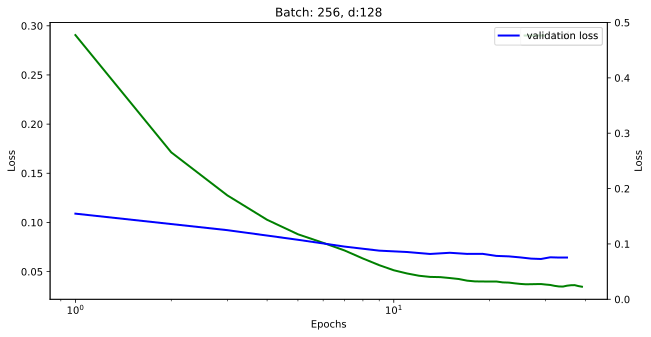

In [ ]:
n=3

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(range(1,len(running_mean(hist_loss,n))+1), running_mean(hist_loss,n), color='green', linestyle='-', label='train loss')
ax1.legend()
ax2 = ax1.twinx()
ax2.set_ylim((0.,0.5))
ax2.plot(range(1,len(running_mean(hist_vmetric,n))*valid_every+1, valid_every), running_mean(hist_vmetric,n), color='blue', linestyle='-', label='validation loss')
ax2.legend()
ax1.set_xscale("log")
ax2.set_xscale("log")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax2.set_ylabel('Loss')
ax1.set_title("Batch: {}, d:{}".format(batch_size,embed_dim))


## Savings

In [ ]:
torch.cuda.empty_cache()
model_name = name
checkpoint = torch.load(data_PATH+"models/"+model_name)
epoch = checkpoint['epoch']
hist_vloss  = checkpoint['loss']

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
print("Uploaded {}, \nepoch= {}, loss= {}".format(model_name, epoch, hist_vloss[-1]))

Uploaded 5layer_MNIST.pth, 
epoch= 87, loss= 0.026934883390099574


## Prediction

In [ ]:
dist = 0.3
num_to_mask = int(dist*N/patch_size**2)

H=28
W=28
C=1

batch_element,_ = next(iter(test_loader))

inp_data = batch_element.permute(0,2,3,1).view(-1,N,1)
inp_data = inp_data.to(device)
inp_data = img_to_patch_batch(inp_data,patch_size=patch_size) ###########

model.eval()

mask_token = torch.zeros(a,dtype=torch.float32).unsqueeze(0).unsqueeze(0).expand(batch_size, num_to_mask, a).to(device)

masked_mae, non_masked_mae, inp_images, masked_images, pred_images = test_model(model, inp_data, device, patch_size, num_to_mask, mask_token, H, W, C)

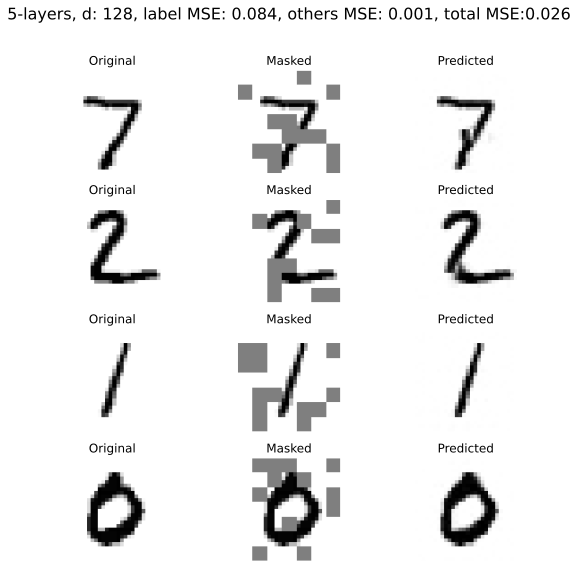

In [ ]:
title = "5-layers, d: {}, label MSE: {:.3f}, others MSE: {:.3f}, total MSE:{:.3f}".format(embed_dim, masked_mae.item(), non_masked_mae.item(), dist*masked_mae.item()+(1-dist)*non_masked_mae.item())
plot_images_grid(inp_images, masked_images, pred_images, num_images=4, overall_title=title)


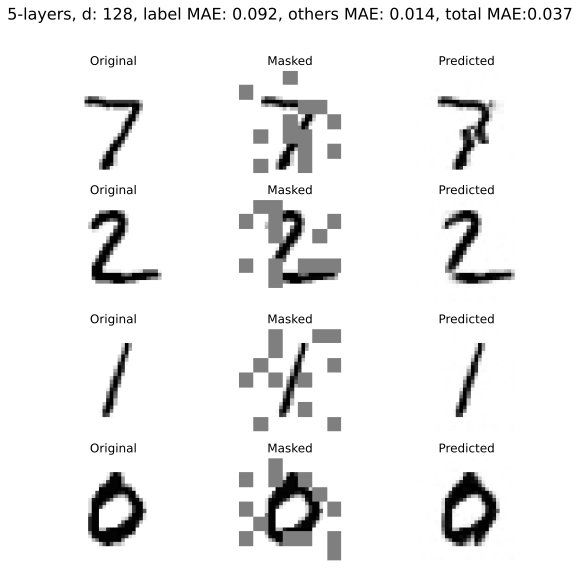

In [ ]:
title = "5-layers, d: {}, label MAE: {:.3f}, others MAE: {:.3f}, total MAE:{:.3f}".format(embed_dim, masked_mae.item(), non_masked_mae.item(), dist*masked_mae.item()+(1-dist)*non_masked_mae.item())
plot_images_grid(inp_images, masked_images, pred_images, num_images=4, overall_title=title)


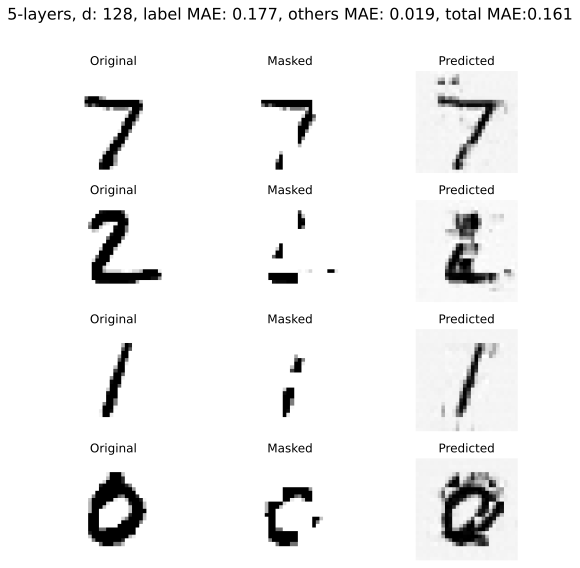

In [ ]:
title = "5-layers, d: {}, label MAE: {:.3f}, others MAE: {:.3f}, total MAE:{:.3f}".format(embed_dim, masked_mae.item(), non_masked_mae.item(), dist*masked_mae.item()+(1-dist)*non_masked_mae.item())
plot_images_grid(inp_images, masked_images, pred_images, num_images=4, overall_title=title)


# SGD training MNIST 5-layers DENOISING

In [ ]:
name = "5layer_MNIST_DENOISING.pth"

z=1

epochs = 100

embed_dim = 128
layers=5
patch_size = 4
patch_dim = patch_size
a=(patch_size*patch_size)

#d=8
#d_low = 0
#h=0

num_patches = int(N/(patch_size**2))
num_to_mask = 1

model = VIT_k_layers(embed_dim=embed_dim,
                     MLP_hidden_dim = 4*embed_dim,
                     num_channels=1,
                     num_heads=1,
                     num_layers=layers,
                     patch_size=patch_size,
                     num_patches=int(N/patch_size**2))

optimizer = optim.AdamW(model.parameters(), lr=1e-3)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(epochs/3),int(2*epochs/3)], gamma=0.1)

# move the model into the GPU
model.to(device)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(int(num_patches), a))
else:
  summary(model, input_size=(a,num_patches))

print("#################")
print("Real number of trainable params:")
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
print("#################")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 49, 128]           2,176
PositionalEncoding-2              [-1, 49, 128]               0
         LayerNorm-3              [-1, 49, 128]             256
            Linear-4              [-1, 49, 384]          49,536
            Linear-5              [-1, 49, 128]          16,512
Multihead_Attention-6              [-1, 49, 128]               0
         LayerNorm-7              [-1, 49, 128]             256
            Linear-8              [-1, 49, 512]          66,048
              GELU-9              [-1, 49, 512]               0
          Dropout-10              [-1, 49, 512]               0
           Linear-11              [-1, 49, 128]          65,664
          Dropout-12              [-1, 49, 128]               0
   AttentionBlock-13              [-1, 49, 128]               0
        LayerNorm-14              [-1,

In [ ]:
valid_every = 2

#training loop
import time

save_best_model = SaveBestModel(data_PATH+"models/"+name)

# lists to save loss and metric history
hist_loss = []
hist_metric = []
hist_vloss = []
hist_vmetric = []

t_in = time.time()

mask_token = torch.zeros(a,dtype=torch.float32).unsqueeze(0).unsqueeze(0).expand(batch_size, num_to_mask, a).to(device)

#loop over epochs
for epoch in tqdm(range(epochs)):
    t0 = time.time()

    #training step
    model.train()

    train_loss = 0.0
    train_metric = 0.0
    counter = 0
    for batch_element in train_loader_reducted: #takes a batch from the train dataloader
        counter += 1
        inp_data = batch_element
        inp_data = inp_data.to(device)
        std_0 = inp_data.std(dim=-2, keepdim=True)
        std_0[std_0 == 0] = 1
        inp_data_old = custom_clamp(inp_data+torch.randn_like(inp_data)*z, min=-1, max=+1, std_0=std_0)

        inp_data = img_to_patch_batch(inp_data,patch_size=patch_size) ###########
        inp_data_old = img_to_patch_batch(inp_data_old,patch_size=patch_size) ###########

        pred = model(inp_data_old, mask=None) #get prediction for batch

        loss = F.mse_loss(pred,inp_data)
        metric = 1-F.l1_loss(pred, inp_data) #compute metric

        train_loss += loss.item() #update total loss
        train_metric += metric.item() #update total metric

        # backpropagation
        loss.backward()
        # update weights
        optimizer.step()
        # set to zero gradients for the next step
        optimizer.zero_grad()

    # normalize loss and metric by number of batches
    train_loss = train_loss/counter
    train_metric = train_metric/counter

    # update history
    hist_loss.append(train_loss)
    hist_metric.append(train_metric)

    if((epoch%valid_every==0) and (epoch>0)):

        # evaluation setp (same as trainign but w/o backpropagation)
        model.eval()

        vali_loss = 0.0
        vali_metric = 0.0
        counter = 0
        with torch.no_grad():
            for batch_element,_ in test_loader:
                counter += 1
                inp_data = batch_element.permute(0,2,3,1).view(-1,N,1)
                inp_data = inp_data.to(device)
                std_0 = inp_data.std(dim=-2, keepdim=True)
                std_0[std_0 == 0] = 1
                inp_data_old = custom_clamp(inp_data+torch.randn_like(inp_data)*z, min=-1, max=+1, std_0=std_0)

                inp_data = img_to_patch_batch(inp_data,patch_size=patch_size) ###########
                inp_data_old = img_to_patch_batch(inp_data_old,patch_size=patch_size) ###########

                pred = model(inp_data_old, mask=None) #get prediction for batch

                vloss = F.mse_loss(pred,inp_data)
                vmetric = 1-F.l1_loss(pred, inp_data) #compute metric

                vali_loss += vloss.item()
                vali_metric += vmetric.item()

        vali_loss = vali_loss/counter
        vali_metric = vali_metric/counter

        hist_vloss.append(vali_loss)
        hist_vmetric.append(vali_metric)

        #save best model
        elapsed_time = time.time()-t0

        time_from_in = time.time()-t_in

        save_best_model(train_loss, train_metric, vali_loss, vali_metric, epoch, model, optimizer, lr_scheduler, hist_vloss, hist_vmetric, time_from_in)

        elapsed_time = time.time()-t0
        # update learning rate schedule
        lr_scheduler.step()
        current_lr = lr_scheduler.get_last_lr()[0]
        if (epoch<10 and (epoch>0)):
            print("epoch: %d, time(s): %.2f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f,  lr : %1.2e" % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric,current_lr))


  0%|          | 0/100 [00:00<?, ?it/s]

Saving best model for epoch: 3, train loss: 7.0669e-02, train metric= 8.7371e-01, val loss: 6.6782e-02, val metric: 8.7782e-01, lr: 1.00e-03, t: 20.3

epoch: 3, time(s): 8.83, train loss: 0.070669, train metric: 0.873713, vali loss: 0.066782, vali metric: 0.877822,  lr : 1.00e-03
Saving best model for epoch: 5, train loss: 5.7000e-02, train metric= 8.9170e-01, val loss: 5.3635e-02, val metric: 8.9698e-01, lr: 1.00e-03, t: 35.8

epoch: 5, time(s): 9.27, train loss: 0.057000, train metric: 0.891700, vali loss: 0.053635, vali metric: 0.896978,  lr : 1.00e-03
Saving best model for epoch: 7, train loss: 4.6965e-02, train metric= 9.0504e-01, val loss: 4.5605e-02, val metric: 9.0782e-01, lr: 1.00e-03, t: 50.1

epoch: 7, time(s): 8.32, train loss: 0.046965, train metric: 0.905037, vali loss: 0.045605, vali metric: 0.907817,  lr : 1.00e-03
Saving best model for epoch: 9, train loss: 4.2558e-02, train metric= 9.1277e-01, val loss: 4.2176e-02, val metric: 9.1366e-01, lr: 1.00e-03, t: 64.2

epoch:

KeyboardInterrupt: 

## Trainings

Text(0.5, 1.0, 'Batch: 256, d:128')

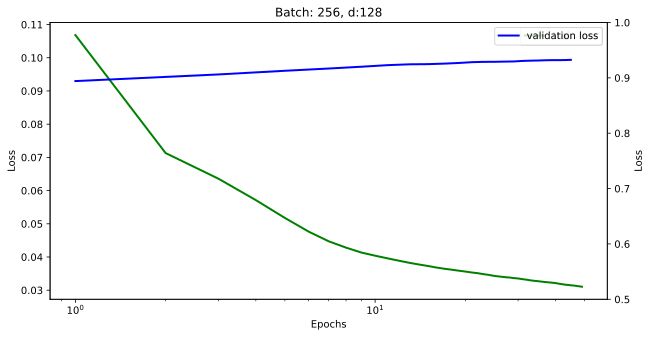

In [ ]:
n=3

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(range(1,len(running_mean(hist_loss,n))+1), running_mean(hist_loss,n), color='green', linestyle='-', label='train loss')
ax1.legend()
ax2 = ax1.twinx()
ax2.set_ylim((0.5,1))
ax2.plot(range(1,len(running_mean(hist_vmetric,n))*valid_every+1, valid_every), running_mean(hist_vmetric,n), color='blue', linestyle='-', label='validation loss')
ax2.legend()
ax1.set_xscale("log")
ax2.set_xscale("log")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax2.set_ylabel('Loss')
ax1.set_title("Batch: {}, d:{}".format(batch_size,embed_dim))


## Savings

In [ ]:
torch.cuda.empty_cache()
model_name = name
checkpoint = torch.load(data_PATH+"models/"+model_name)
epoch = checkpoint['epoch']
hist_vloss  = checkpoint['loss']

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
print("Uploaded {}, \nepoch= {}, loss= {}".format(model_name, epoch, hist_vloss[-1]))

Uploaded 5layer_MNIST_DENOISING.pth, 
epoch= 49, loss= 0.0333356149494648


## Prediction

In [ ]:
z = 0.7

H=28
W=28
C=1

batch_element,_ = next(iter(test_loader))

inp_data = batch_element.permute(0,2,3,1).view(-1,N,1)
inp_data = inp_data.to(device)
std_0 = inp_data.std(dim=-2, keepdim=True)
std_0[std_0 == 0] = 1
inp_data_old = custom_clamp(inp_data+torch.randn_like(inp_data)*z, min=-1, max=+1, std_0=std_0)

inp_data = img_to_patch_batch(inp_data,patch_size=patch_size) ###########
inp_data_old = img_to_patch_batch(inp_data_old,patch_size=patch_size) ###########

model.eval()

accuracy, inp_images, masked_images, pred_images = test_model_diff(model, inp_data, inp_data_old, device, patch_size, H, W, C)

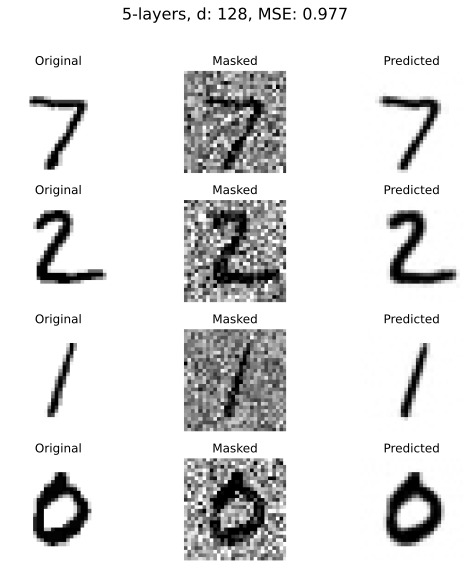

In [ ]:
title = "5-layers, d: {}, MSE: {:.3f}".format(embed_dim, accuracy)
plot_images_grid(inp_images, masked_images, pred_images, num_images=4, overall_title=title)


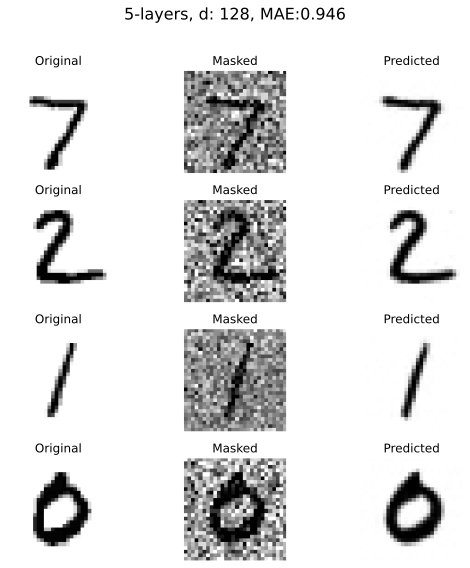

In [ ]:
title = "5-layers, d: {}, MAE:{:.3f}".format(embed_dim, accuracy)
plot_images_grid(inp_images, masked_images, pred_images, num_images=4, overall_title=title)


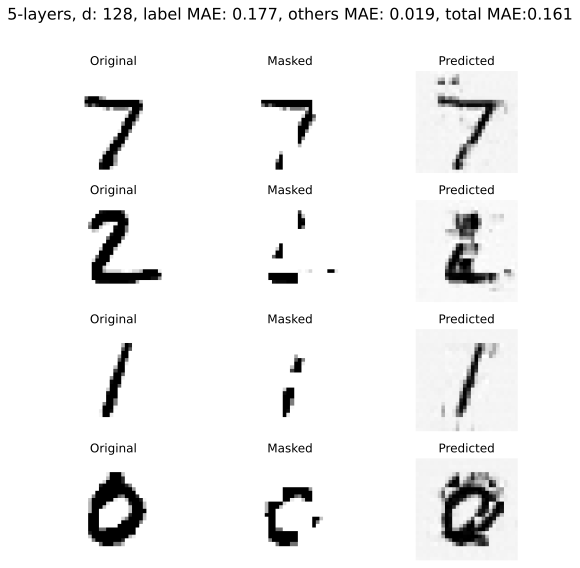

In [ ]:
title = "5-layers, d: {}, label MAE: {:.3f}, others MAE: {:.3f}, total MAE:{:.3f}".format(embed_dim, masked_mae.item(), non_masked_mae.item(), dist*masked_mae.item()+(1-dist)*non_masked_mae.item())
plot_images_grid(inp_images, masked_images, pred_images, num_images=4, overall_title=title)


PREDICTION TRAINED MASKED

In [ ]:
z = 0.7

H=28
W=28
C=1

batch_element,_ = next(iter(test_loader))

inp_data = batch_element.permute(0,2,3,1).view(-1,N,1)
inp_data = inp_data.to(device)
inp_data_old = custom_clamp(inp_data+torch.randn_like(inp_data)*z, min=-1, max=+1)

inp_data = img_to_patch_batch(inp_data,patch_size=patch_size) ###########
inp_data_old = img_to_patch_batch(inp_data_old,patch_size=patch_size) ###########

model.eval()

accuracy, inp_images, masked_images, pred_images = test_model_diff(model, inp_data, inp_data_old, device, patch_size, H, W, C)

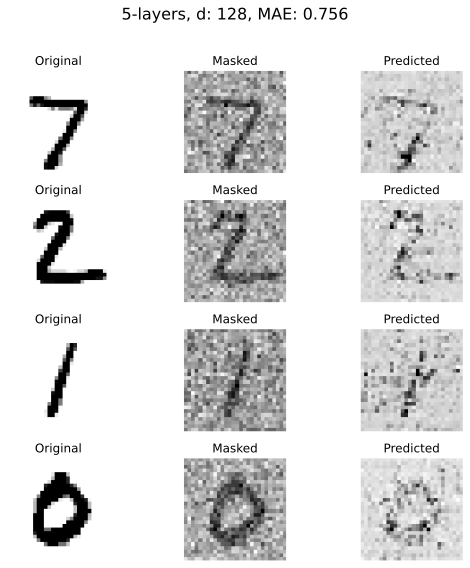

In [ ]:
title = "5-layers, d: {}, MAE: {:.3f}".format(embed_dim, accuracy)
plot_images_grid(inp_images, masked_images, pred_images, num_images=4, overall_title=title)


# SGD training MNIST spherical NO MLP HEADS 5-rep

In [ ]:
name = "5rep_MNIST.pth"
#name = "5rep_MNIST_patch2.pth"

epochs = 100

embed_dim = 128
layers=1
patch_size = 4
patch_dim = patch_size
a=(patch_size*patch_size)

'''
d=8
d_low = 0
h=0
'''

num_patches = int(N/(patch_size**2))
num_to_mask = 1

model = VIT_k_rep(embed_dim=embed_dim,
                     MLP_hidden_dim = 4*embed_dim,
                     num_channels=1,
                     num_heads=1,
                     num_layers=layers,
                     patch_size=patch_size,
                     num_patches=int(N/patch_size**2))

optimizer = optim.AdamW(model.parameters(), lr=1e-4)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(epochs/3),int(2*epochs/3)], gamma=0.1)

# move the model into the GPU
model.to(device)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(int(num_patches), a))
else:
  summary(model, input_size=(a,num_patches))

print("#################")
print("Real number of trainable params:")
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
print("#################")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 49, 128]           2,176
PositionalEncoding-2              [-1, 49, 128]               0
           Dropout-3              [-1, 49, 128]               0
         LayerNorm-4              [-1, 49, 128]             256
         LayerNorm-5              [-1, 49, 128]             256
            Linear-6              [-1, 49, 384]          49,536
            Linear-7              [-1, 49, 384]          49,536
            Linear-8              [-1, 49, 128]          16,512
            Linear-9              [-1, 49, 128]          16,512
Multihead_Attention-10              [-1, 49, 128]               0
Multihead_Attention-11              [-1, 49, 128]               0
        LayerNorm-12              [-1, 49, 128]             256
        LayerNorm-13              [-1, 49, 128]             256
           Linear-14              [

In [ ]:
valid_every = 2

#training loop
import time

save_best_model = SaveBestModel(data_PATH+"models/"+name)

# lists to save loss and metric history
hist_loss = []
hist_metric = []
hist_vloss = []
hist_vmetric = []

t_in = time.time()

mask_token = torch.zeros(a,dtype=torch.float32).unsqueeze(0).unsqueeze(0).expand(batch_size, num_to_mask, a).to(device)

#loop over epochs
for epoch in tqdm(range(epochs)):
    t0 = time.time()

    #training step
    model.train()

    train_loss = 0.0
    train_metric = 0.0
    counter = 0
    for batch_element in train_loader_reducted: #takes a batch from the train dataloader
        counter += 1
        inp_data = batch_element
        inp_data = inp_data.to(device)
        inp_data = img_to_patch_batch(inp_data,patch_size=patch_size) ###########

        rand_index = torch.randint(num_patches, (batch_size, num_to_mask,)).to(device)
        rand_index_expanded = rand_index.unsqueeze(-1).expand(batch_size, num_to_mask, inp_data.size(-1))

        labels = torch.gather(inp_data, 1, rand_index_expanded).squeeze()

        masked_inp_data = inp_data.clone()
        masked_inp_data.scatter_(1, rand_index_expanded, mask_token)

        mask = torch.ones(batch_size, num_patches, dtype=torch.float32).to(device)
        mask.scatter_(1, rand_index, 0)
        attention_mask = mask.unsqueeze(1).unsqueeze(2)

        random_repetitions = np.random.randint(3,7) #random number from 3 to 6

        pred = model(masked_inp_data, repetitions=random_repetitions, mask=attention_mask) #get prediction for batch

        loss = loss_func(pred, labels, inp_data, rand_index_expanded) #compute loss
        metric = accuracy(pred, labels, rand_index_expanded) #compute metric

        train_loss += loss.item() #update total loss
        train_metric += metric.item() #update total metric

        # backpropagation
        loss.backward()
        # update weights
        optimizer.step()
        # set to zero gradients for the next step
        optimizer.zero_grad()

    # normalize loss and metric by number of batches
    train_loss = train_loss/counter
    train_metric = train_metric/counter

    # update history
    hist_loss.append(train_loss)
    hist_metric.append(train_metric)

    lr_scheduler.step()

    if((epoch%valid_every==0) and (epoch>0)):

        # evaluation setp (same as trainign but w/o backpropagation)
        model.eval()

        vali_loss = 0.0
        vali_metric = 0.0
        counter = 0
        with torch.no_grad():
            for batch_element,_ in test_loader:
                counter += 1
                inp_data = batch_element.permute(0,2,3,1).view(-1,N,1)
                inp_data = inp_data.to(device)
                inp_data = img_to_patch_batch(inp_data,patch_size=patch_size) ###########

                rand_index = torch.randint(num_patches, (batch_size, num_to_mask,)).to(device)
                rand_index_expanded = rand_index.unsqueeze(-1).expand(batch_size, num_to_mask, inp_data.size(-1))

                labels = torch.gather(inp_data, 1, rand_index_expanded).squeeze()

                masked_inp_data = inp_data.clone()
                masked_inp_data.scatter_(1, rand_index_expanded, mask_token)

                mask = torch.ones(batch_size, num_patches, dtype=torch.float32).to(device)
                mask.scatter_(1, rand_index, 0)
                attention_mask = mask.unsqueeze(1).unsqueeze(2)

                random_repetitions = np.random.randint(3,7) #random number from 3 to 6

                pred = model(masked_inp_data, repetitions=random_repetitions, mask=attention_mask) #get prediction for batch

                vloss = loss_func(pred, labels, inp_data, rand_index_expanded) #compute loss
                vmetric = accuracy(pred, labels, rand_index_expanded) #compute metric

                vali_loss += vloss.item()
                vali_metric += vmetric.item()

        vali_loss = vali_loss/counter
        vali_metric = vali_metric/counter

        hist_vloss.append(vali_loss)
        hist_vmetric.append(vali_metric)

        #save best model
        elapsed_time = time.time()-t0

        time_from_in = time.time()-t_in

        save_best_model(train_loss, train_metric, vali_loss, vali_metric, epoch, model, optimizer, lr_scheduler, hist_vloss, hist_vmetric, time_from_in)

        elapsed_time = time.time()-t0
        # update learning rate schedule

        current_lr = lr_scheduler.get_last_lr()[0]
        if (epoch<10 and (epoch>0)):
            print("epoch: %d, time(s): %.2f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f,  lr : %1.2e" % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric,current_lr))


  0%|          | 0/100 [00:00<?, ?it/s]

Saving best model for epoch: 3, train loss: 5.6305e-01, train metric= 4.9734e-01, val loss: 5.1799e-01, val metric: 4.9005e-01, lr: 1.00e-04, t: 26.7

epoch: 3, time(s): 10.55, train loss: 0.563049, train metric: 0.497339, vali loss: 0.517993, vali metric: 0.490048,  lr : 1.00e-04
Saving best model for epoch: 5, train loss: 4.3042e-01, train metric= 4.3330e-01, val loss: 4.2525e-01, val metric: 4.1543e-01, lr: 1.00e-04, t: 45.7

epoch: 5, time(s): 11.09, train loss: 0.430422, train metric: 0.433297, vali loss: 0.425248, vali metric: 0.415431,  lr : 1.00e-04
Saving best model for epoch: 7, train loss: 3.7802e-01, train metric= 4.0404e-01, val loss: 3.7985e-01, val metric: 4.0775e-01, lr: 1.00e-04, t: 63.9

epoch: 7, time(s): 10.45, train loss: 0.378023, train metric: 0.404039, vali loss: 0.379849, vali metric: 0.407748,  lr : 1.00e-04
Saving best model for epoch: 9, train loss: 3.3822e-01, train metric= 3.7456e-01, val loss: 3.2605e-01, val metric: 3.4540e-01, lr: 1.00e-04, t: 82.4

epo

KeyboardInterrupt: 

## Trainings

Text(0.5, 1.0, 'Batch: 256, d:128')

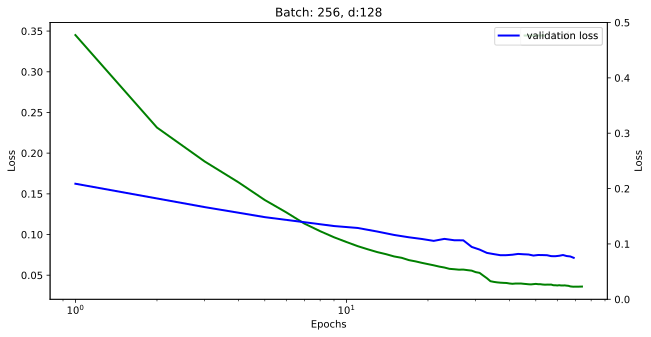

In [ ]:
n=3

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(range(1,len(running_mean(hist_loss,n))+1), running_mean(hist_loss,n), color='green', linestyle='-', label='train loss')
ax1.legend()
ax2 = ax1.twinx()
ax2.set_ylim((0.,0.5))
ax2.plot(range(1,len(running_mean(hist_vmetric,n))*valid_every+1, valid_every), running_mean(hist_vmetric,n), color='blue', linestyle='-', label='validation loss')
ax2.legend()
ax1.set_xscale("log")
ax2.set_xscale("log")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax2.set_ylabel('Loss')
ax1.set_title("Batch: {}, d:{}".format(batch_size,embed_dim))


## Savings

In [ ]:
torch.cuda.empty_cache()
model_name = name
checkpoint = torch.load(data_PATH+"models/"+model_name)
epoch = checkpoint['epoch']
hist_vloss = checkpoint['loss']

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
print("Uploaded {}, \nepoch= {}, loss= {}".format(model_name, epoch, hist_vloss[-1]))

Uploaded 5rep_MNIST.pth, 
epoch= 75, loss= 0.03721977445559624


# SGD training MNIST spherical NO MLP HEADS 5-rep DIFFUSION

In [ ]:
name = "5rep_MNIST_DIFFUSION.pth"

z=1

epochs = 100

embed_dim = 128
layers=1
patch_size = 4
patch_dim = patch_size
a=(patch_size*patch_size)

'''
d=8
d_low = 0
h=0
'''

num_patches = int(N/(patch_size**2))
num_to_mask = 1

model = VIT_k_rep(embed_dim=embed_dim,
                     MLP_hidden_dim = 4*embed_dim,
                     num_channels=1,
                     num_heads=1,
                     num_layers=layers,
                     patch_size=patch_size,
                     num_patches=int(N/patch_size**2))

optimizer = optim.AdamW(model.parameters(), lr=1e-3)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(epochs/3),int(2*epochs/3)], gamma=0.1)

# move the model into the GPU
model.to(device)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(int(num_patches), a))
else:
  summary(model, input_size=(a,num_patches))

print("#################")
print("Real number of trainable params:")
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
print("#################")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 49, 128]           2,176
PositionalEncoding-2              [-1, 49, 128]               0
           Dropout-3              [-1, 49, 128]               0
         LayerNorm-4              [-1, 49, 128]             256
         LayerNorm-5              [-1, 49, 128]             256
            Linear-6              [-1, 49, 384]          49,536
            Linear-7              [-1, 49, 384]          49,536
            Linear-8              [-1, 49, 128]          16,512
            Linear-9              [-1, 49, 128]          16,512
Multihead_Attention-10              [-1, 49, 128]               0
Multihead_Attention-11              [-1, 49, 128]               0
        LayerNorm-12              [-1, 49, 128]             256
        LayerNorm-13              [-1, 49, 128]             256
           Linear-14              [

In [ ]:
valid_every = 2

#training loop
import time

save_best_model = SaveBestModel(data_PATH+"models/"+name)

# lists to save loss and metric history
hist_loss = []
hist_metric = []
hist_vloss = []
hist_vmetric = []

t_in = time.time()

mask_token = torch.zeros(a,dtype=torch.float32).unsqueeze(0).unsqueeze(0).expand(batch_size, num_to_mask, a).to(device)

#loop over epochs
for epoch in tqdm(range(epochs)):
    t0 = time.time()

    #training step
    model.train()

    train_loss = 0.0
    train_metric = 0.0
    counter = 0
    for batch_element in train_loader_reducted: #takes a batch from the train dataloader
        counter += 1
        inp_data = batch_element
        inp_data = inp_data.to(device)

        std_0 = inp_data.std(dim=-2, keepdim=True)
        std_0[std_0 == 0] = 1
        inp_data_old = custom_clamp(inp_data+torch.randn_like(inp_data)*z, min=-1, max=+1, std_0=std_0)

        inp_data = img_to_patch_batch(inp_data,patch_size=patch_size) ###########
        inp_data_old = img_to_patch_batch(inp_data_old,patch_size=patch_size) ###########

        random_repetitions = np.random.randint(3,7) #random number from 3 to 6

        pred = model(inp_data_old, repetitions=random_repetitions, mask=None) #get prediction for batch

        loss = F.mse_loss(pred,inp_data)
        metric = 1-F.l1_loss(pred, inp_data) #compute metric

        train_loss += loss.item() #update total loss
        train_metric += metric.item() #update total metric

        # backpropagation
        loss.backward()
        # update weights
        optimizer.step()
        # set to zero gradients for the next step
        optimizer.zero_grad()

    # normalize loss and metric by number of batches
    train_loss = train_loss/counter
    train_metric = train_metric/counter

    # update history
    hist_loss.append(train_loss)
    hist_metric.append(train_metric)

    lr_scheduler.step()

    if((epoch%valid_every==0) and (epoch>0)):

        # evaluation setp (same as trainign but w/o backpropagation)
        model.eval()

        vali_loss = 0.0
        vali_metric = 0.0
        counter = 0
        with torch.no_grad():
            for batch_element,_ in test_loader:
                counter += 1
                inp_data = batch_element.permute(0,2,3,1).view(-1,N,1)
                inp_data = inp_data.to(device)
                std_0 = inp_data.std(dim=-2, keepdim=True)
                std_0[std_0 == 0] = 1
                inp_data_old = custom_clamp(inp_data+torch.randn_like(inp_data)*z, min=-1, max=+1, std_0=std_0)

                inp_data = img_to_patch_batch(inp_data,patch_size=patch_size) ###########
                inp_data_old = img_to_patch_batch(inp_data_old,patch_size=patch_size) ###########

                random_repetitions = np.random.randint(3,7) #random number from 3 to 6

                pred = model(inp_data_old, repetitions=random_repetitions, mask=None) #get prediction for batch

                vloss = F.mse_loss(pred,inp_data)
                vmetric = 1-F.l1_loss(pred, inp_data) #compute metric


                vali_loss += vloss.item()
                vali_metric += vmetric.item()

        vali_loss = vali_loss/counter
        vali_metric = vali_metric/counter

        hist_vloss.append(vali_loss)
        hist_vmetric.append(vali_metric)

        #save best model
        elapsed_time = time.time()-t0

        time_from_in = time.time()-t_in

        save_best_model(train_loss, train_metric, vali_loss, vali_metric, epoch, model, optimizer, lr_scheduler, hist_vloss, hist_vmetric, time_from_in)

        elapsed_time = time.time()-t0
        # update learning rate schedule

        current_lr = lr_scheduler.get_last_lr()[0]
        if (epoch<10 and (epoch>0)):
            print("epoch: %d, time(s): %.2f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f,  lr : %1.2e" % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric,current_lr))


  0%|          | 0/100 [00:00<?, ?it/s]

Saving best model for epoch: 3, train loss: 8.5960e-02, train metric= 8.5222e-01, val loss: 8.2275e-02, val metric: 8.5822e-01, lr: 1.00e-03, t: 18.8

epoch: 3, time(s): 8.08, train loss: 0.085960, train metric: 0.852225, vali loss: 0.082275, vali metric: 0.858220,  lr : 1.00e-03
Saving best model for epoch: 5, train loss: 7.7111e-02, train metric= 8.6954e-01, val loss: 7.4712e-02, val metric: 8.7578e-01, lr: 1.00e-03, t: 32.1

epoch: 5, time(s): 7.90, train loss: 0.077111, train metric: 0.869536, vali loss: 0.074712, vali metric: 0.875785,  lr : 1.00e-03
Saving best model for epoch: 7, train loss: 7.3296e-02, train metric= 8.7574e-01, val loss: 7.1787e-02, val metric: 8.7593e-01, lr: 1.00e-03, t: 45.1

epoch: 7, time(s): 7.74, train loss: 0.073296, train metric: 0.875744, vali loss: 0.071787, vali metric: 0.875929,  lr : 1.00e-03
Saving best model for epoch: 9, train loss: 7.0634e-02, train metric= 8.7590e-01, val loss: 6.7985e-02, val metric: 8.8212e-01, lr: 1.00e-03, t: 57.6

epoch:

KeyboardInterrupt: 

## Trainings

Text(0.5, 1.0, 'Batch: 256, d:128')

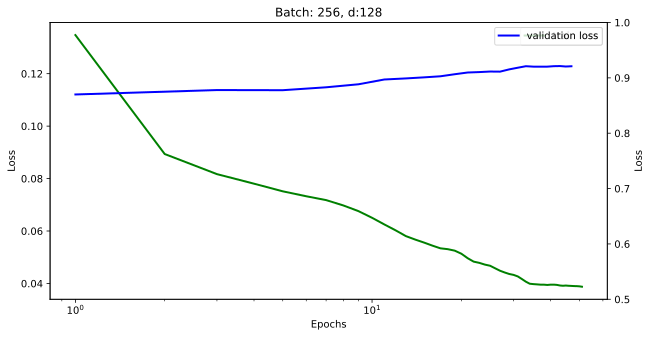

In [ ]:
n=3

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(range(1,len(running_mean(hist_loss,n))+1), running_mean(hist_loss,n), color='green', linestyle='-', label='train loss')
ax1.legend()
ax2 = ax1.twinx()
ax2.set_ylim((0.5,1))
ax2.plot(range(1,len(running_mean(hist_vmetric,n))*valid_every+1, valid_every), running_mean(hist_vmetric,n), color='blue', linestyle='-', label='validation loss')
ax2.legend()
ax1.set_xscale("log")
ax2.set_xscale("log")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax2.set_ylabel('Loss')
ax1.set_title("Batch: {}, d:{}".format(batch_size,embed_dim))


## Savings

In [ ]:
torch.cuda.empty_cache()
model_name = name
checkpoint = torch.load(data_PATH+"models/"+model_name)
epoch = checkpoint['epoch']
hist_vloss  = checkpoint['loss']

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
print("Uploaded {}, \nepoch= {}, loss= {}".format(model_name, epoch, hist_vloss[-1]))

Uploaded 5rep_MNIST_DIFFUSION.pth, 
epoch= 53, loss= 0.03915981432566276


# Contractive mapping analysis in embedding space

## Generate

In [ ]:
#Training data
normalized = False
layer_norm = False
boundary = "fixed"
#mask_type = "autoregressive"
mask_type = "first_step"

big_patch = None

l=0.1
g=0.9
dist=0.3
l_increase= None
clamp=10

q_max = 101
q_instants = torch.tensor([1,1,5,20,100])

#q_max = int(1/(1-g))+1#
#q_instants = torch.tensor([1,1,2,20,int(1/(1-g))])

#q_max = 1001
#q_instants = torch.tensor([1,1,100,200,1000])

inp_data_original,_ = next(iter(test_loader))
inp_data_original = inp_data_original.permute(0,2,3,1).view(-1,N,1)
#inp_data_original = next(iter(train_loader_reducted))

#inp_data_original = inp_data_original[:16]

inp_data_original = img_to_patch_batch(inp_data_original,patch_size).to(device)

#inp_data_original = inp_data_original/(torch.linalg.norm(inp_data_original, dim=-1).unsqueeze(-1))

model.eval()

with torch.no_grad():
    tensor_images = torch.zeros((len(q_instants)+1,inp_data_original.shape[0],inp_data_original.shape[1]))

    tensor_images, overlap_curves, list_indexes, overlap_spins  = q_repeating_spherical_patch_embed_de_embed_original(model, inp_data_original, patch_size, q_max, q_instants, normalized_sphere=normalized, d=dist, mask_type=mask_type, g=g, l=l, layer_norm=layer_norm, boundary=boundary, big_patch=big_patch, l_increase=l_increase, clamp=clamp)

    #tensor_images, overlap_curves, list_indexes, overlap_spins  = q_repeating_spherical_patch_embed_de_embed(model, inp_data_original, patch_size, q_max, q_instants, normalized_sphere=normalized, d=dist, mask_type=mask_type, g=g, l=l, layer_norm=layer_norm, boundary=boundary, big_patch=big_patch, l_increase=l_increase, clamp=clamp)

  0%|          | 0/101 [00:00<?, ?it/s]

In [ ]:
torch.save(overlap_curves,data_PATH+"data/ov_curves_5_rep_dist0_3.pth")

In [ ]:
torch.save(overlap_curves,data_PATH+"data/ov_curves_5_rep_dist0_03.pth")

In [ ]:
torch.save(tensor_images,data_PATH+"data/tensors_5_rep_dist0_3.pth")   #3,5

In [ ]:
torch.save(tensor_images,data_PATH+"data/tensors_5_rep_dist0_03.pth")   #1,18

## Histograms

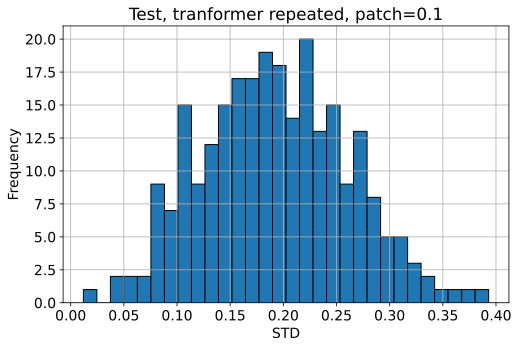

In [ ]:
plt.rcParams.update({'font.size': 14})

directory = "hist_transf_dist0_3_patch4"

B_ = 256
N_ = int(784/(patch_size**2))

text = "Test, tranformer repeated, patch={}".format(l, g, patch_size)
flattened_std_values = compute_and_plot_std_histogram(tensor_images[3], list_indexes, patch_size, text, save_name=directory)

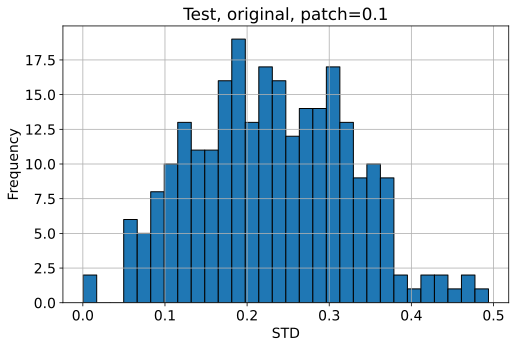

In [ ]:
plt.rcParams.update({'font.size': 14})

directory = "hist_original_dist0_3_patch2"

B_ = 256
N_ = int(784/(patch_size**2))

text = "Test, original, patch={}".format(l, g, patch_size)
flattened_std_values = compute_and_plot_std_histogram(tensor_images[0], list_indexes, patch_size, text, save_name=directory)

## Embed128 patch4 P40000 batch256 l1 5-rep


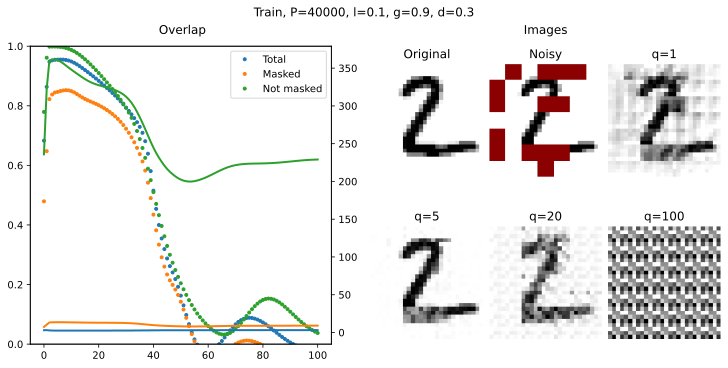

In [ ]:
batch_element = 1
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, dist, title=title)

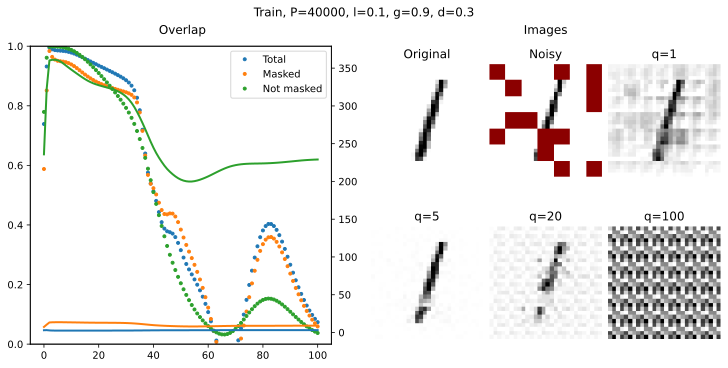

In [ ]:
batch_element = 2
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, dist, title=title)

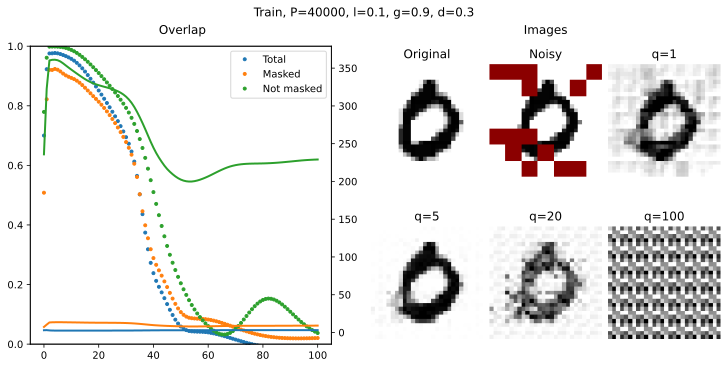

In [ ]:
batch_element = 3

title = "Train, P={}, l={}, g={}".format(P, l, g)

print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, dist, title=title)

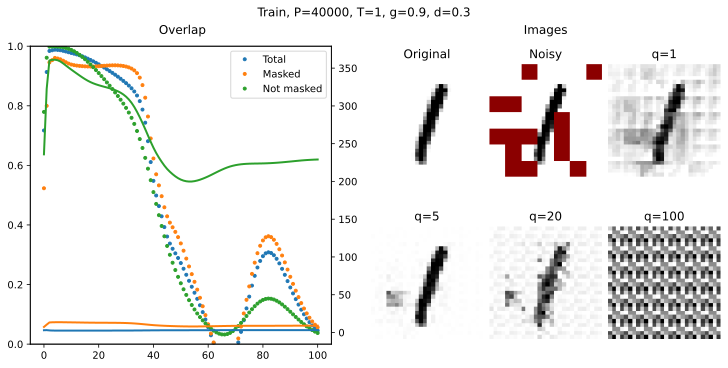

In [ ]:
batch_element = 5

title = "Train, P={}, T=1, g={}".format(P, g)

print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, dist, title=title)

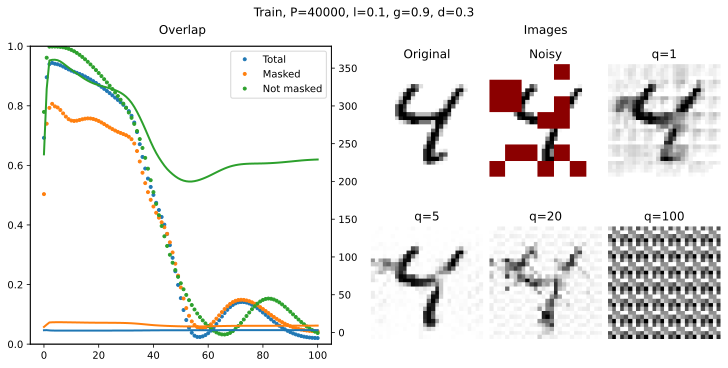

In [ ]:
batch_element = 6
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, dist, title=title)

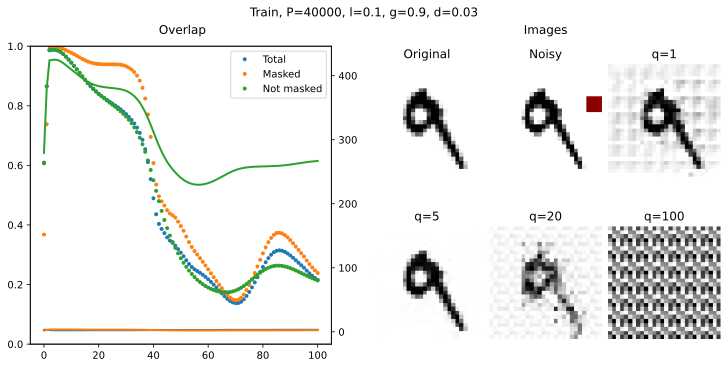

In [ ]:
batch_element = 7
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, dist, title=title)

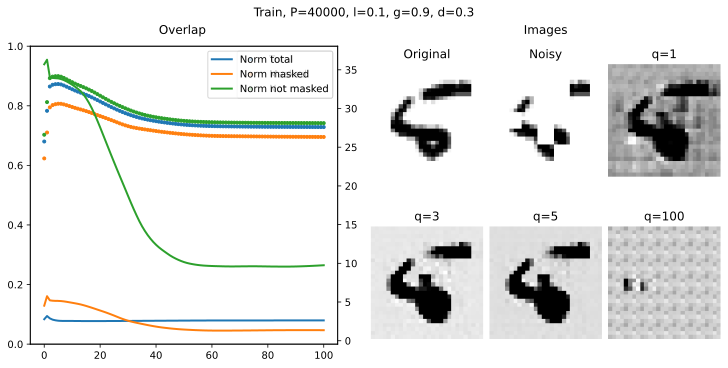

In [ ]:
batch_element = 8
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, dist, title=title)

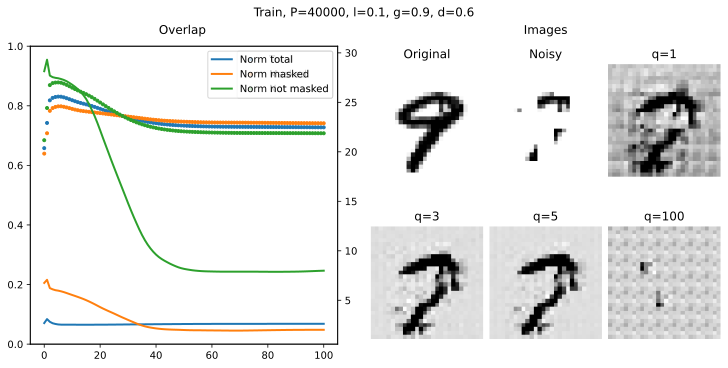

In [ ]:
batch_element = 9
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, dist, title=title)

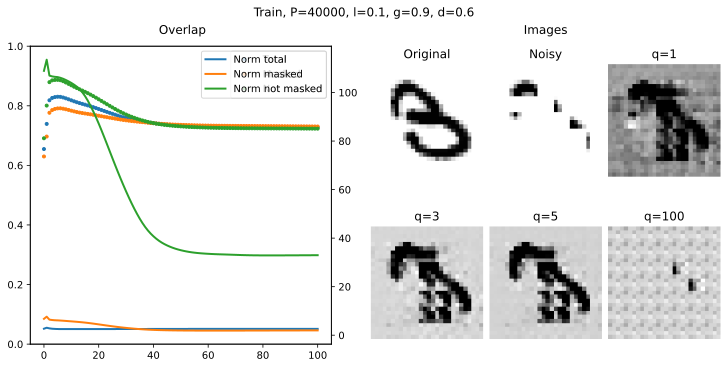

In [ ]:
batch_element = 18
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, dist, title=title)

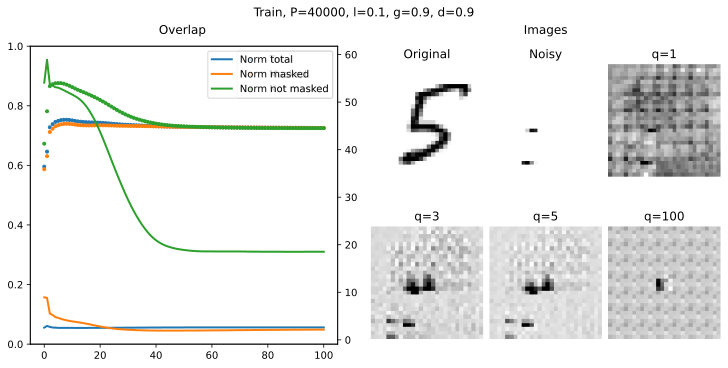

In [ ]:
batch_element = 24
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, dist, title=title)

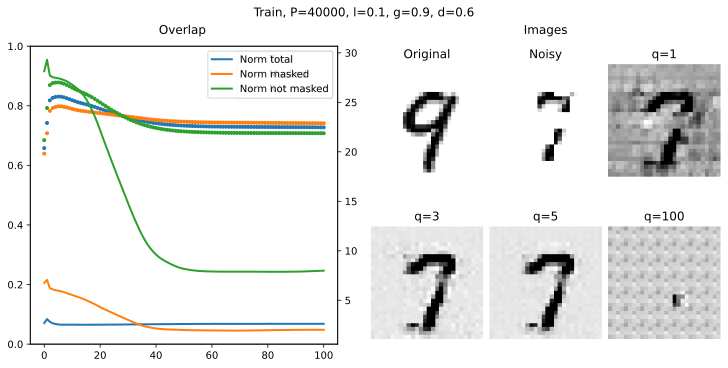

In [ ]:
batch_element = 12
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, dist, title=title)

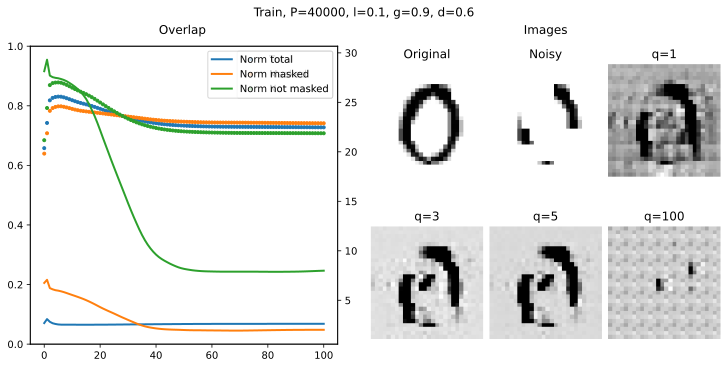

In [ ]:
batch_element = 13
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, dist, title=title)

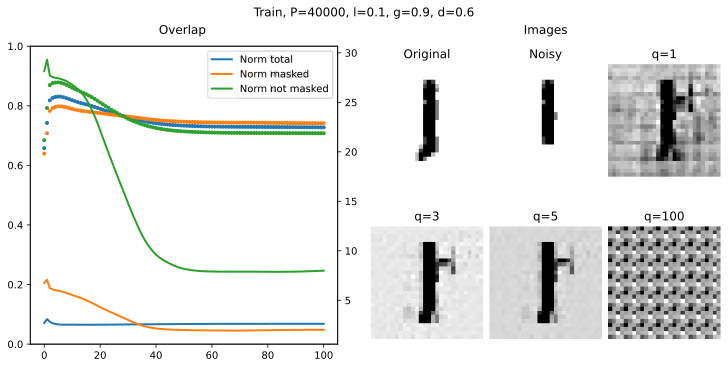

In [ ]:
batch_element = 14
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, dist, title=title)

IndexError: index 16 is out of bounds for dimension 1 with size 16

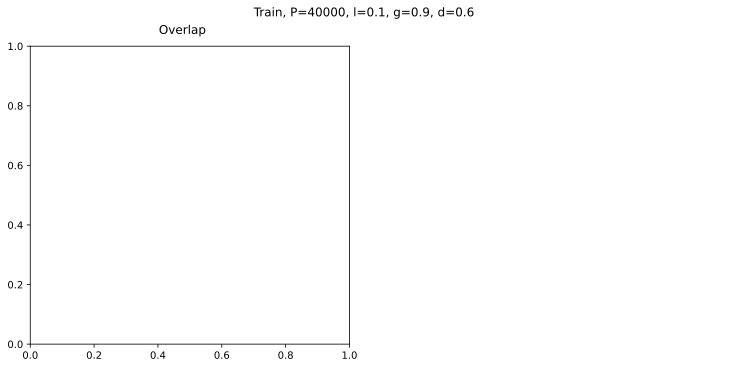

In [ ]:
batch_element = 1
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, dist, title=title)

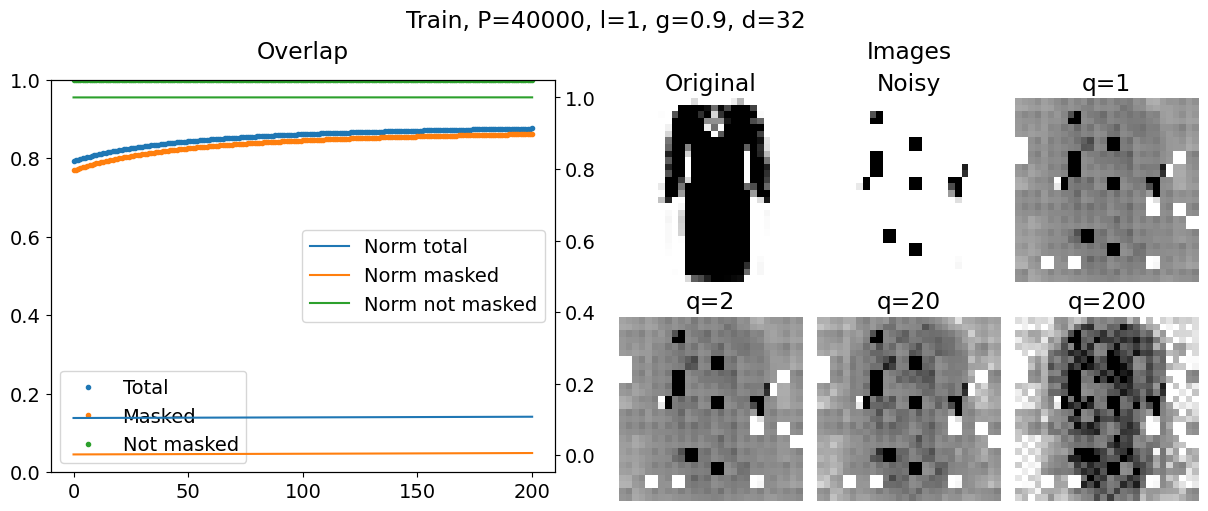

In [ ]:
batch_element = 6
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, d, title=title)

### Embed128 patch2 P40000 batch16 l1 5-rep


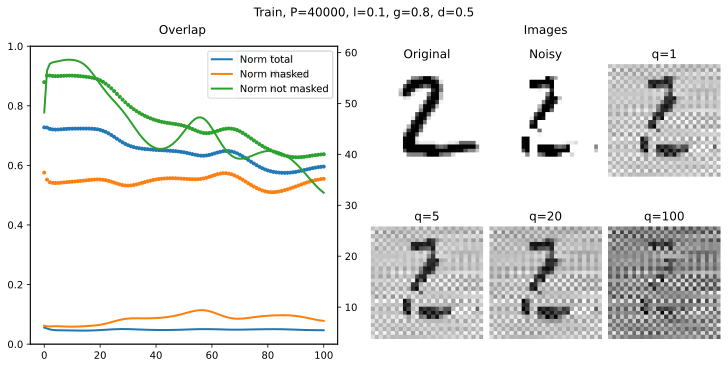

In [ ]:
batch_element = 1
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, dist, title=title)

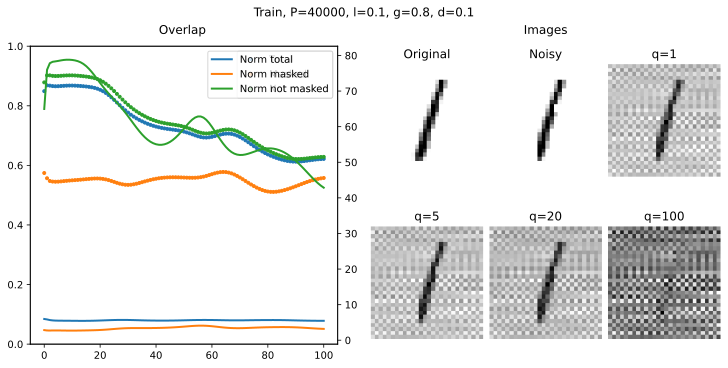

In [ ]:
batch_element = 2
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, dist, title=title)

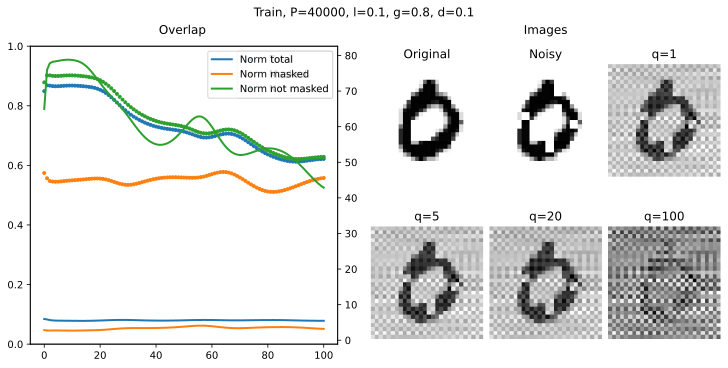

In [ ]:
batch_element = 3

title = "Train, P={}, l={}, g={}".format(P, l, g)

print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, dist, title=title)

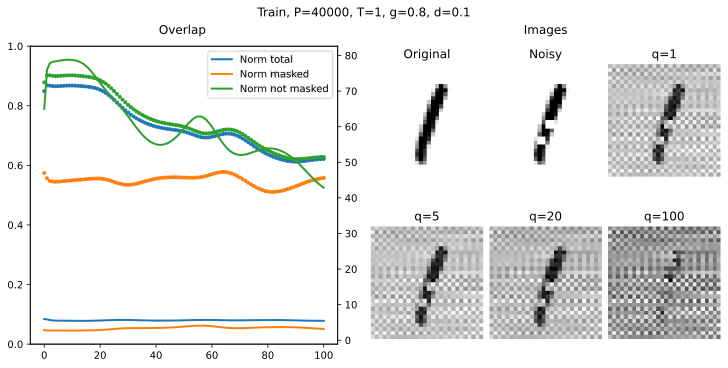

In [ ]:
batch_element = 5

title = "Train, P={}, T=1, g={}".format(P, g)

print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, dist, title=title)

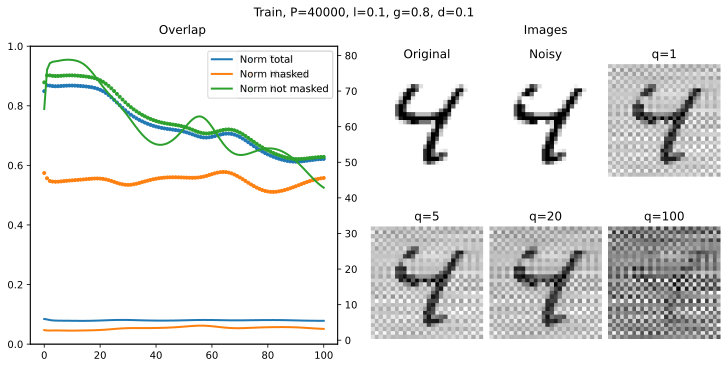

In [ ]:
batch_element = 6
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, dist, title=title)

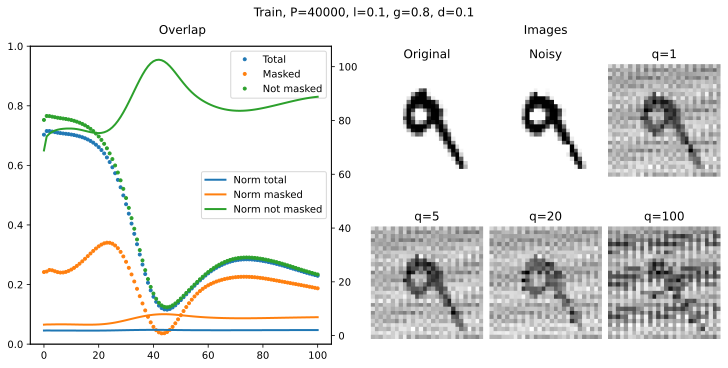

In [ ]:
batch_element = 7
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, dist, title=title)

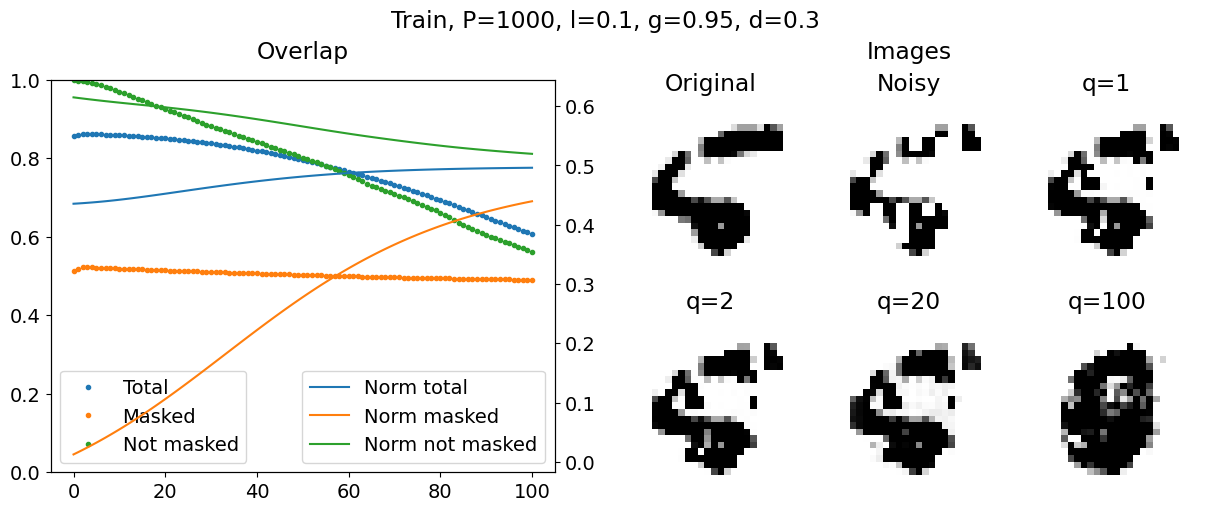

In [ ]:
batch_element = 8
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, dist, title=title)

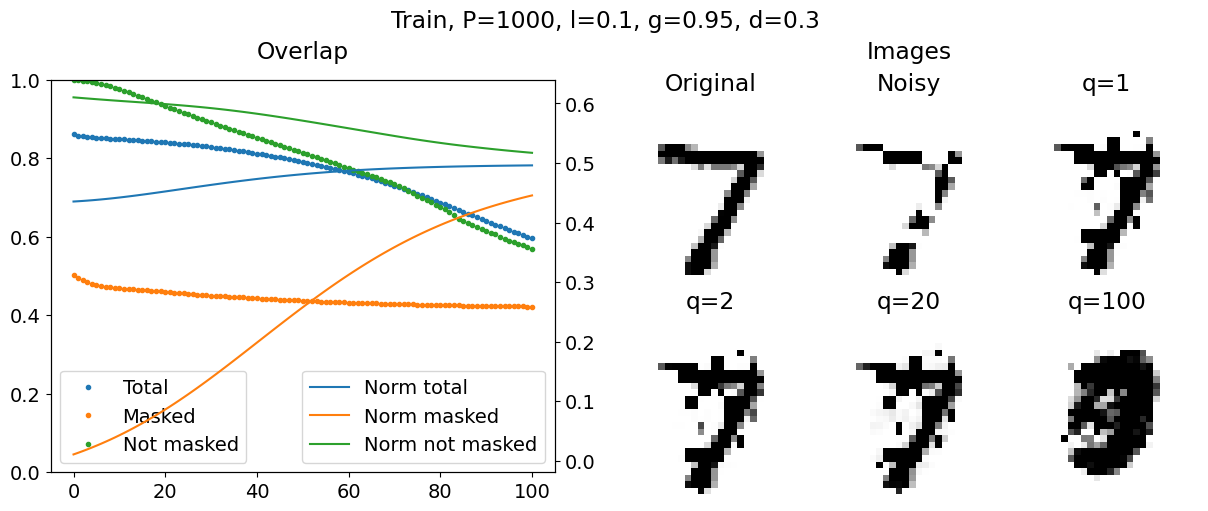

In [ ]:
batch_element = 0
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, dist, title=title)

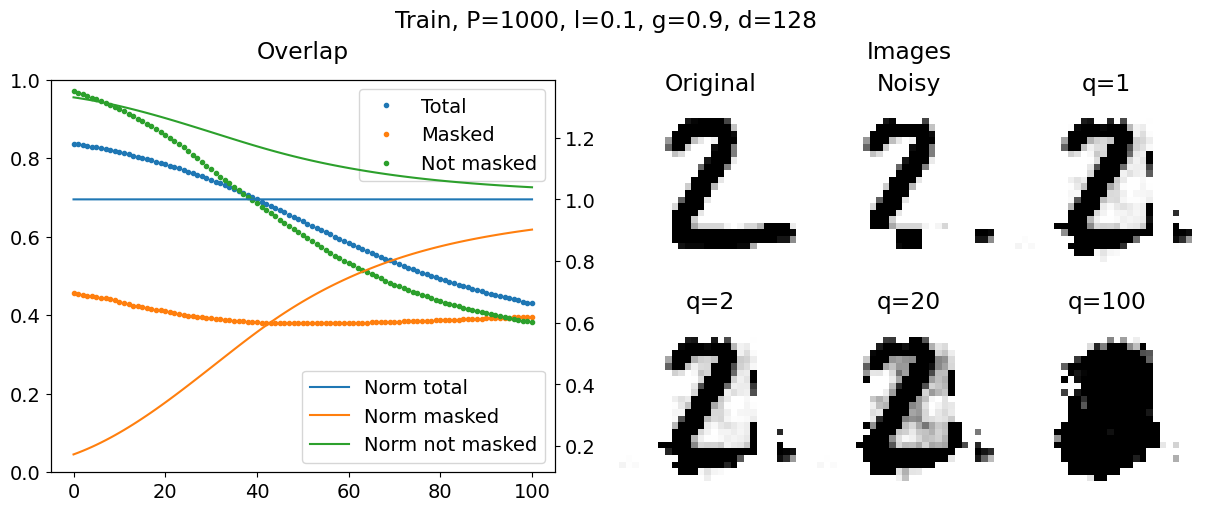

In [ ]:
batch_element = 1
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, dist, title=title)

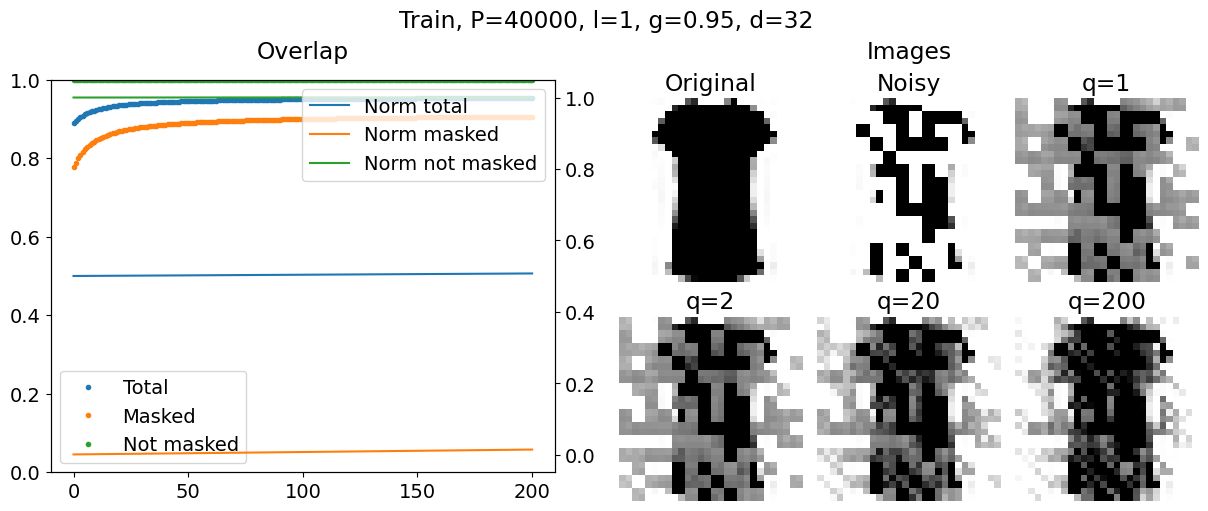

In [ ]:
batch_element = 4
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, d, title=title)

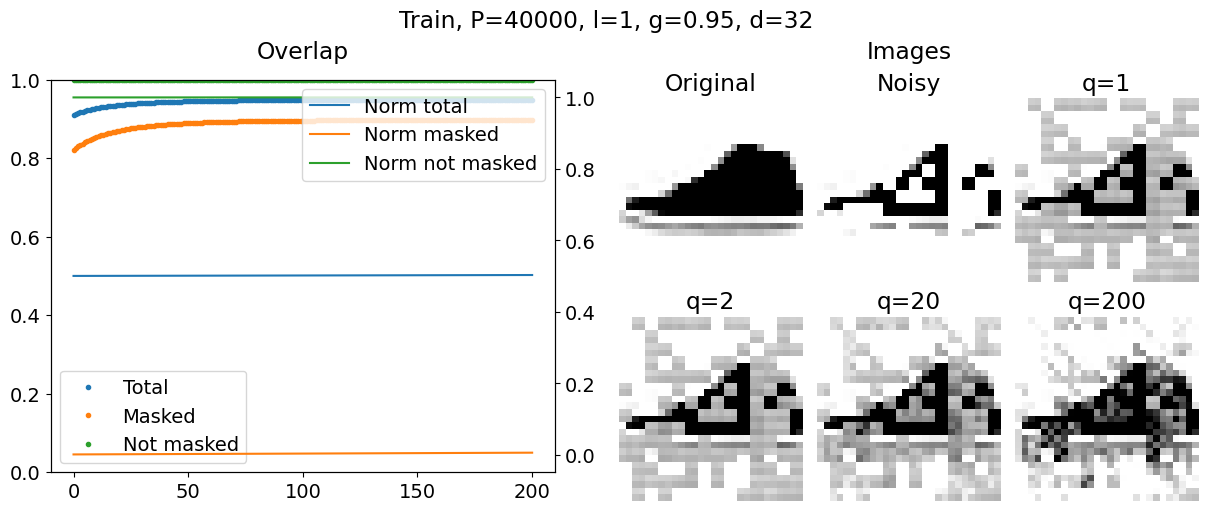

In [ ]:
batch_element = 6
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, d, title=title)

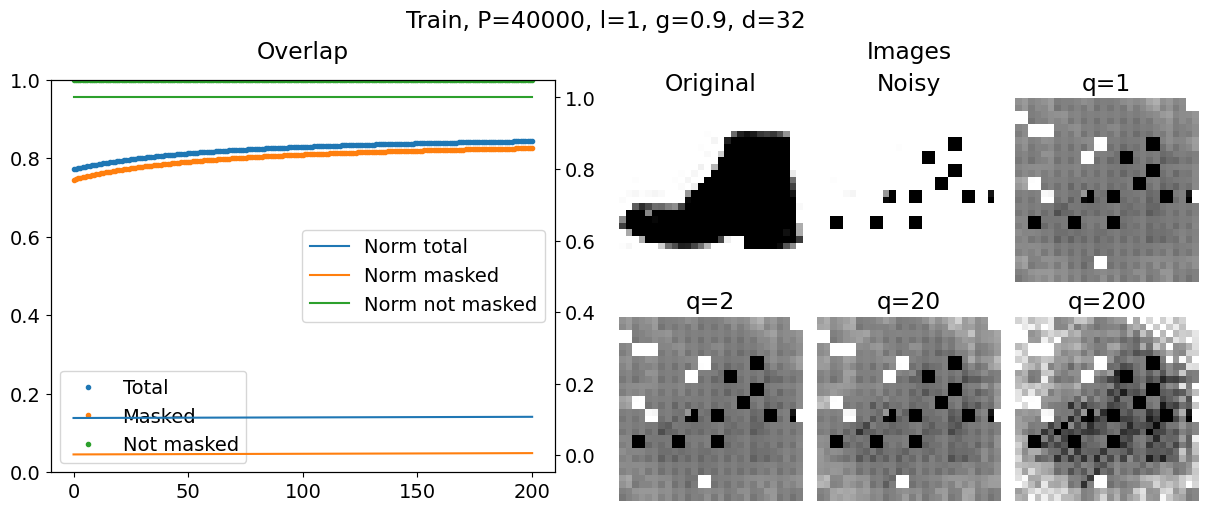

In [ ]:
batch_element = 0
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, d, title=title)

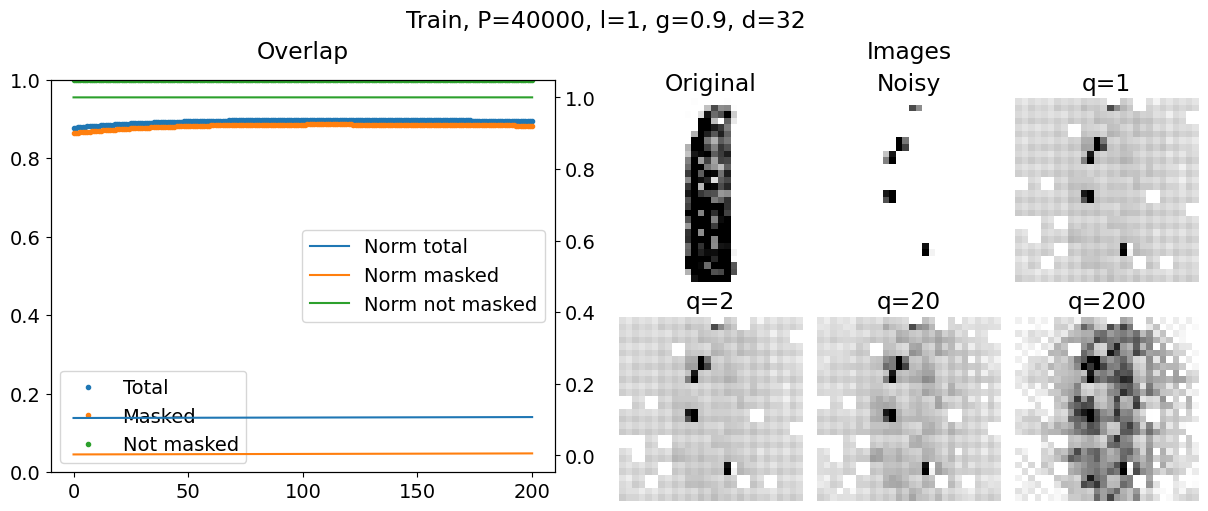

In [ ]:
batch_element = 1
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, d, title=title)

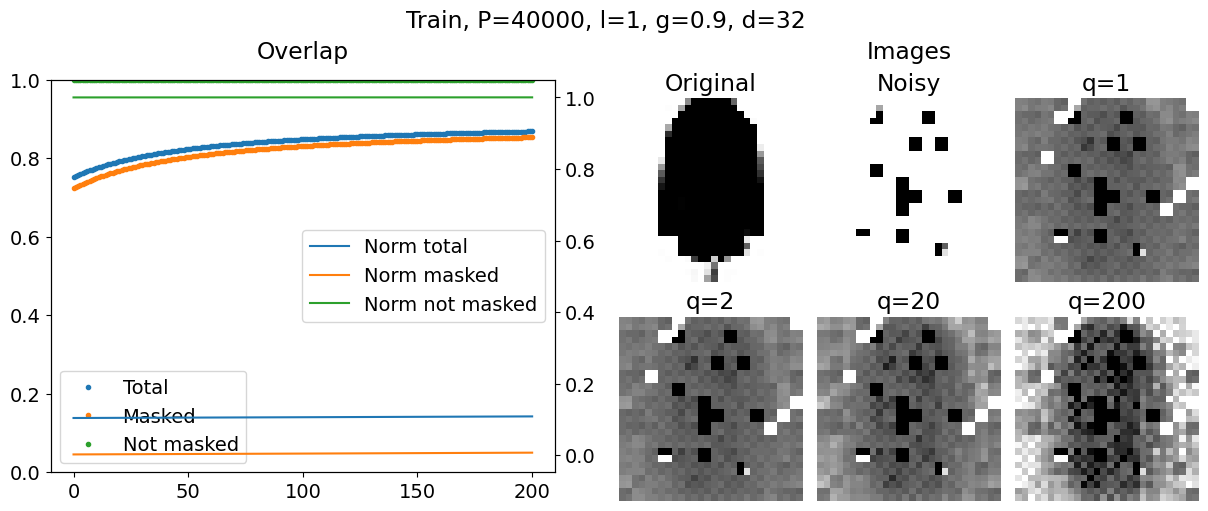

In [ ]:
batch_element = 3
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, d, title=title)

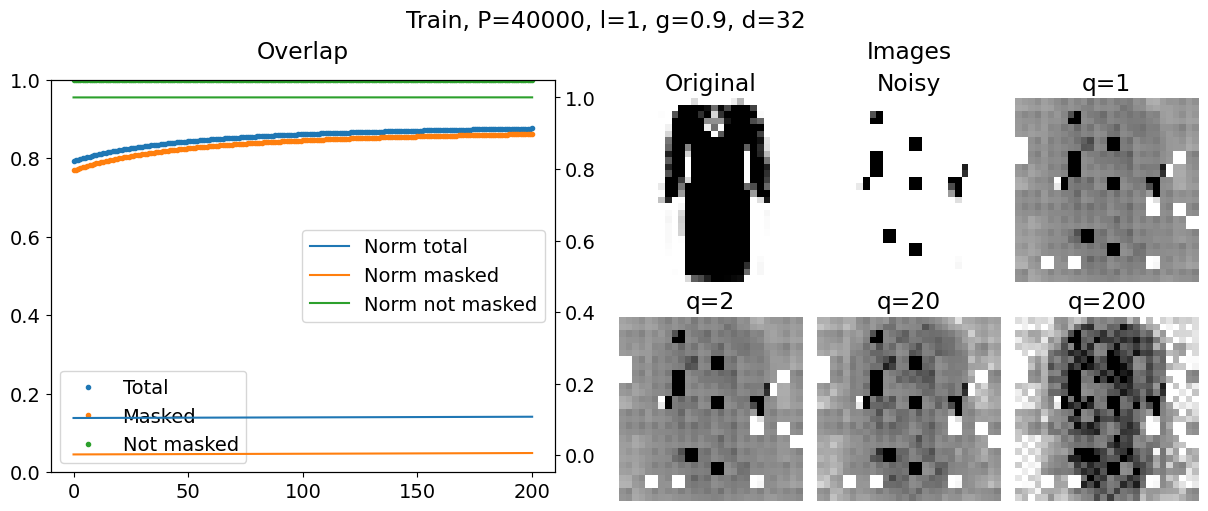

In [ ]:
batch_element = 6
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, d, title=title)

# Contractive analysis in embedding space, DIFFUSION

## Generate

In [ ]:
#Training data
normalized = False
layer_norm = False
boundary = "fixed"
#mask_type = "autoregressive"
mask_type = "first_step"

big_patch = None

z=3.7

q_max = 101
q_instants = torch.tensor([1,1,5,30,100])

inp_data_original,_ = next(iter(test_loader))
inp_data_original = inp_data_original.permute(0,2,3,1).view(-1,N,1).to(device)

std_0 = inp_data_original.std(dim=-2, keepdim=True)
std_0[std_0 == 0] = 1
inp_data_old = custom_clamp(inp_data_original+torch.randn_like(inp_data_original)*z, min=-1, max=+1, std_0=std_0).to(device)


#inp_data_original = img_to_patch_batch(inp_data_original,patch_size).to(device)
#inp_data_old = img_to_patch_batch(inp_data_old,patch_size).to(device)

#inp_data_original = inp_data_original/(torch.linalg.norm(inp_data_original, dim=-1).unsqueeze(-1))

model.eval()

with torch.no_grad():
    tensor_images = torch.zeros((len(q_instants)+1,inp_data_original.shape[0],inp_data_original.shape[1]))

    tensor_images, overlap_curves  = q_repeating_spherical_patch_embed_de_embed_original_DIFFUSION(model, inp_data_original, inp_data_old, patch_size, q_max, q_instants, normalized_sphere=normalized, mask_type=mask_type, boundary=boundary, big_patch=big_patch)

    #tensor_images, overlap_curves, list_indexes, overlap_spins  = q_repeating_spherical_patch_embed_de_embed(model, inp_data_original, patch_size, q_max, q_instants, normalized_sphere=normalized, d=dist, mask_type=mask_type, g=g, l=l, layer_norm=layer_norm, boundary=boundary, big_patch=big_patch, l_increase=l_increase, clamp=clamp)

  0%|          | 0/101 [00:00<?, ?it/s]

In [ ]:
torch.save(overlap_curves,data_PATH+"data/ov_curves_5_rep_z0_2.pth")
torch.save(tensor_images,data_PATH+"data/tensors_5_rep_z0_2.pth")   #3,5

In [ ]:
torch.save(overlap_curves,data_PATH+"data/ov_curves_5_rep_z0_7.pth")
torch.save(tensor_images,data_PATH+"data/tensors_5_rep_z0_7.pth")   #3,5

## d=128, patch=4, P=40000, batch=256, 5-rep

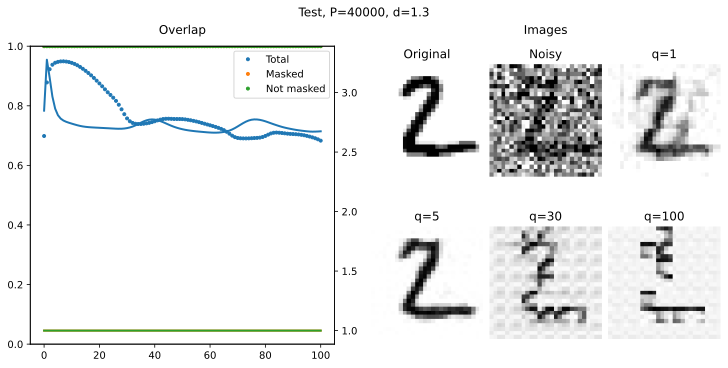

In [ ]:
batch_element = 1
title = "Test, P={}".format(P)
print_q_repeating_diff(tensor_images, overlap_curves, list_indexes=None, q_instants=q_instants, batch_element=batch_element, d=z, title=title)

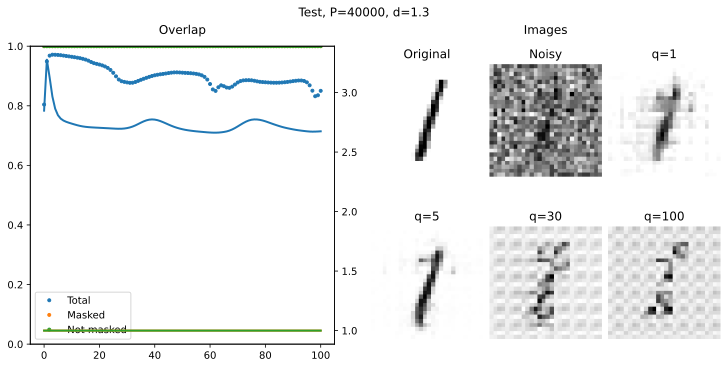

In [ ]:
batch_element = 2
title = "Test, P={}".format(P)
print_q_repeating_diff(tensor_images, overlap_curves, list_indexes=None, q_instants=q_instants, batch_element=batch_element, d=z, title=title)

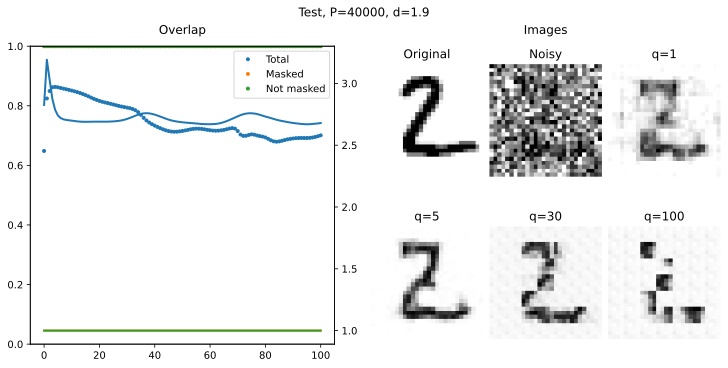

In [ ]:
batch_element = 1
title = "Test, P={}".format(P)
print_q_repeating_diff(tensor_images, overlap_curves, list_indexes=None, q_instants=q_instants, batch_element=batch_element, d=z, title=title)

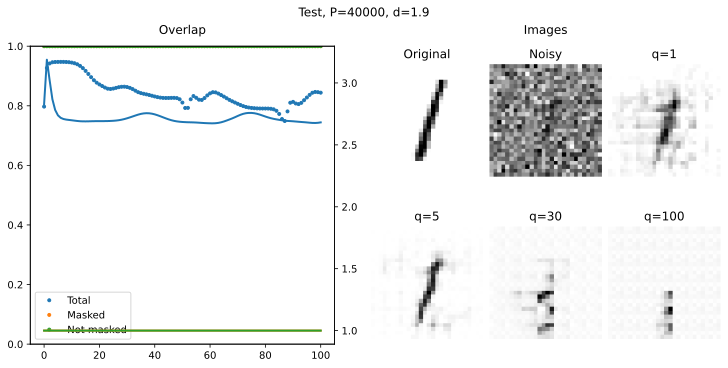

In [ ]:
batch_element = 2
title = "Test, P={}".format(P)
print_q_repeating_diff(tensor_images, overlap_curves, list_indexes=None, q_instants=q_instants, batch_element=batch_element, d=z, title=title)

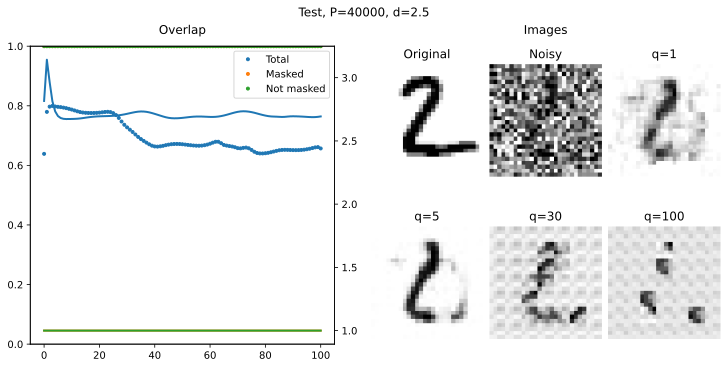

In [ ]:
batch_element = 1
title = "Test, P={}".format(P)
print_q_repeating_diff(tensor_images, overlap_curves, list_indexes=None, q_instants=q_instants, batch_element=batch_element, d=z, title=title)

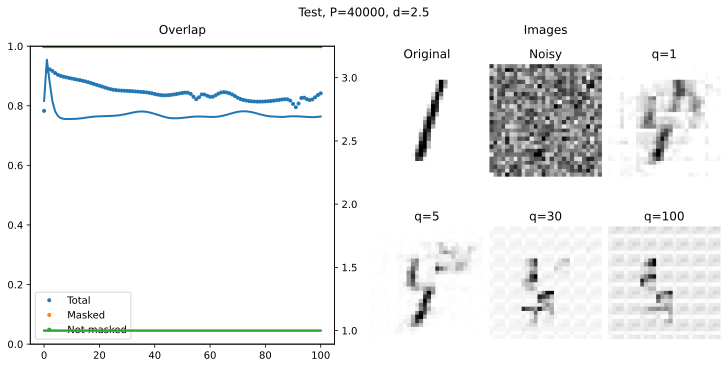

In [ ]:
batch_element = 2
title = "Test, P={}".format(P)
print_q_repeating_diff(tensor_images, overlap_curves, list_indexes=None, q_instants=q_instants, batch_element=batch_element, d=z, title=title)

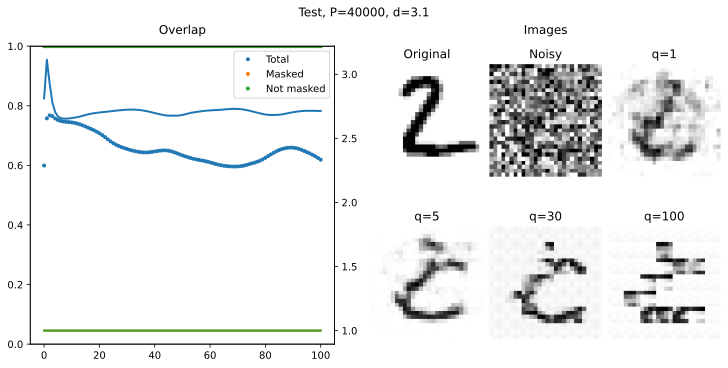

In [ ]:
batch_element = 1
title = "Test, P={}".format(P)
print_q_repeating_diff(tensor_images, overlap_curves, list_indexes=None, q_instants=q_instants, batch_element=batch_element, d=z, title=title)

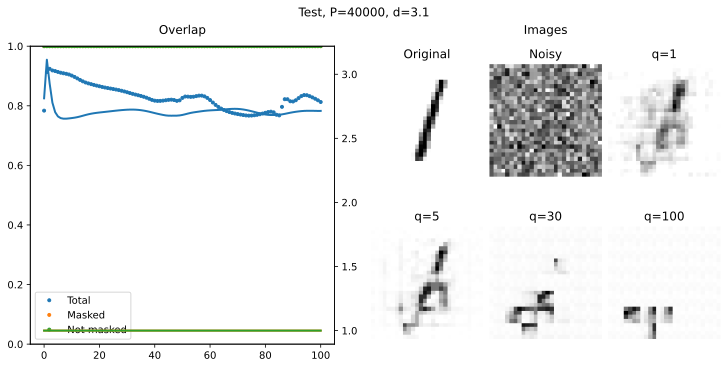

In [ ]:
batch_element = 2
title = "Test, P={}".format(P)
print_q_repeating_diff(tensor_images, overlap_curves, list_indexes=None, q_instants=q_instants, batch_element=batch_element, d=z, title=title)

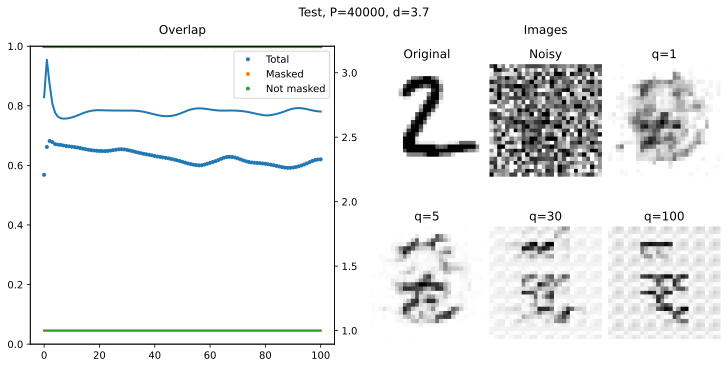

In [ ]:
batch_element = 1
title = "Test, P={}".format(P)
print_q_repeating_diff(tensor_images, overlap_curves, list_indexes=None, q_instants=q_instants, batch_element=batch_element, d=z, title=title)

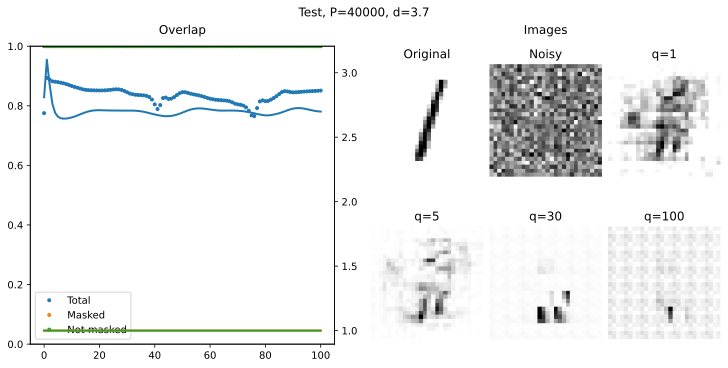

In [ ]:
batch_element = 2
title = "Test, P={}".format(P)
print_q_repeating_diff(tensor_images, overlap_curves, list_indexes=None, q_instants=q_instants, batch_element=batch_element, d=z, title=title)

## d=128, patch=4, P=40000, batch=256, 5-rep, MODEL TRAINED VIA MLM

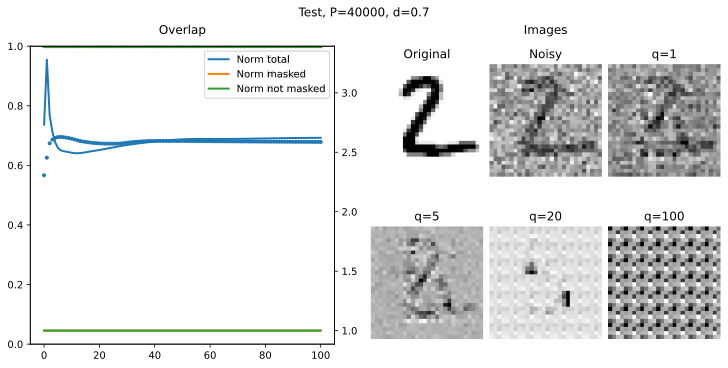

In [ ]:
batch_element = 1
title = "Test, P={}".format(P)
print_q_repeating(tensor_images, overlap_curves, list_indexes=None, q_instants=q_instants, batch_element=batch_element, d=z, title=title)

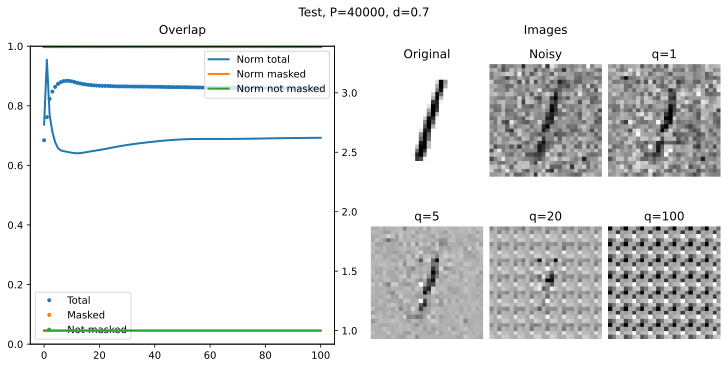

In [ ]:
batch_element = 2
title = "Test, P={}".format(P)
print_q_repeating(tensor_images, overlap_curves, list_indexes=None, q_instants=q_instants, batch_element=batch_element, d=z, title=title)

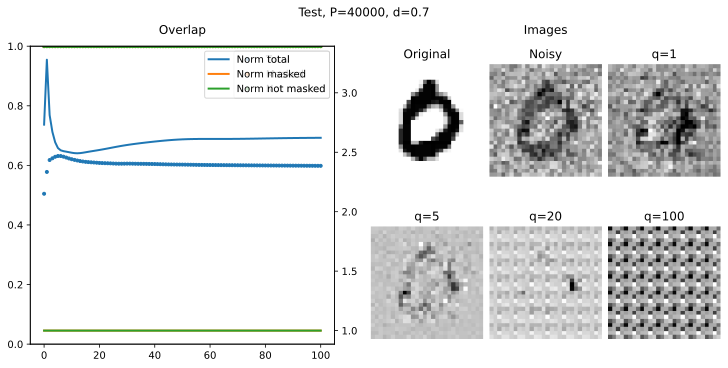

In [ ]:
batch_element = 3
title = "Test, P={}".format(P)
print_q_repeating(tensor_images, overlap_curves, list_indexes=None, q_instants=q_instants, batch_element=batch_element, d=z, title=title)

# NLL-OVERLAP analysis

## Classic

In [ ]:
#Training data
layer_norm = True
normalized = True

l=0.1
g=0.9
dist = 0.3
l_increase= None
clamp=10

q_max = 101
q_instants = torch.tensor([1,1,5,20,100])
e_i_to_compute=20

inp_data_original,_ = next(iter(test_loader))
#inp_data_original = next(iter(train_loader_reducted))
inp_data_original = img_to_patch_spherical(inp_data_original[:16],patch_size).to(device)

#inp_data_noisy = torch.clamp(torch.randn(inp_data_original.shape[0],inp_data_original.shape[1],inp_data_original.shape[2])+0.75,0,1)
#inp_data_noisy = encode_batch_spherical_spin(inp_data_noisy,N)

#inp_data_original = img_to_patch_spherical(inp_data_original,patch_size)
#inp_data_noisy = img_to_patch_spherical(inp_data_noisy,patch_size).to(device)

model.eval()

with torch.no_grad():
    B_ = inp_data_original.shape[0]
    overlap_curves = torch.zeros((q_max, B_,3))
    nll_curves = torch.zeros((q_max, B_))
    original_nll = torch.zeros((B_,2))
    overlap_curves, nll_curves, original_nll,tensor_images = q_repeating_overlap_NLL_spherical_patch_de_embed(model,inp_data_original,patch_size,q_instants,q_max,normalized,dist,g=g,l=l,layer_norm=layer_norm,l_increase=l_increase,clamp=clamp,e_i_to_compute=e_i_to_compute)
    #overlap_curves, nll_curves, original_nll = q_repeating_NLL_spherical_patch(model,inp_data_noisy,patch_size,q_max,d,g=g,l=l,layer_norm=layer_norm,l_increase=l_increase,clamp=clamp,e_i_to_compute=e_i_to_compute)

100%|██████████| 101/101 [00:04<00:00, 24.84it/s]


## Retrieval map

In [ ]:
#Training data
layer_norm = True
normalized_sphere = True

l=0.1
g=0.9
dist_arr = np.arange(0.1,0.9,0.1)
dist = 0.1
l_increase= None
clamp=10

q_max = 1001
q_instants = torch.tensor([1,1,10,100,1000])
e_i_to_compute=20

inp_data_original,_ = next(iter(test_loader))
#inp_data_original = next(iter(train_loader_reducted))
inp_data_original = img_to_patch_spherical(inp_data_original[:16],patch_size).to(device)
B_ = inp_data_original.shape[0]
overlap_curves = torch.zeros((len(dist_arr),q_max, B_,7))
nll_curves = torch.zeros((len(dist_arr),q_max, B_))
original_nll = torch.zeros((len(dist_arr),B_,2))
tensor_images = torch.zeros((len(dist_arr),7,B_,N))
#inp_data_noisy = torch.clamp(torch.randn(inp_data_original.shape[0],inp_data_original.shape[1],inp_data_original.shape[2])+0.75,0,1)
#inp_data_noisy = encode_batch_spherical_spin(inp_data_noisy,N)

#inp_data_original = img_to_patch_spherical(inp_data_original,patch_size)
#inp_data_noisy = img_to_patch_spherical(inp_data_noisy,patch_size).to(device)

model.eval()

for i, dist in enumerate(dist_arr):
    with torch.no_grad():

        overlap_curves[i], nll_curves[i], original_nll[i],tensor_images[i] = q_repeating_overlap_NLL_spherical_patch_de_embed(model,inp_data_original,patch_size,q_instants,q_max,normalized_sphere,dist,g=g,l=l,layer_norm=layer_norm,l_increase=l_increase,clamp=clamp,e_i_to_compute=e_i_to_compute)
        #overlap_curves, nll_curves, original_nll = q_repeating_NLL_spherical_patch(model,inp_data_noisy,patch_size,q_max,d,g=g,l=l,layer_norm=layer_norm,l_increase=l_increase,clamp=clamp,e_i_to_compute=e_i_to_compute)

100%|██████████| 1001/1001 [00:19<00:00, 52.55it/s]


## 5-rep

In [ ]:
q_to_take = np.array([1,10,100,1000])
overlap = torch.zeros(4,8)

for i_q,q in enumerate(q_to_take):
    for i,dist in enumerate(dist_arr):
        overlap[i_q,i] = overlap_curves[i,q,:,1].mean(-1)

plt.figure(figsize=(8,6))
plt.title("P=1000, patch=2, d=8, g=0.9, l_test=0.1")
for i_q,q in enumerate(q_to_take):
    plt.plot(1-dist_arr, overlap[i_q],"o",label="q={}".format(q))
    plt.legend()
plt.ylim((0.5,1))
plt.xlabel("1-Mask distance")
plt.ylabel("MSE distance in real space")